In [1]:
# 라이브러리 임포트
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch import autograd
from torch.utils import data
from torch.optim import Adam

In [2]:
# 난수 생성기가 항상 일정한 값을 출력하게 하기 위해 seed 고정
random_seed = 2021
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)

# Load data

In [3]:
from google.colab import drive


drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/팀 프로젝트/Traffic_prediction/')

Mounted at /content/drive


In [4]:
DATASET_PATH = 'data'

In [5]:
train_df = pd.read_csv(os.path.join(DATASET_PATH, 'train.csv'))
train_df

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200101,0,83247,19128,2611,5161,1588,892,32263,1636,7938,1894,14957,3527,11174,2930,8640,14175,2035,5231,18492,48520,15393,16628,8804,2790,38657,1311,3482,11299,7072,1176,3810,748,3920,2133,3799
1,20200101,1,89309,19027,3337,5502,1650,1043,35609,1644,9896,1967,14682,3420,13884,3062,8349,15654,2417,5483,15283,57904,15834,19785,8483,3381,45759,1162,3849,13180,8771,1283,3763,782,3483,2057,4010
2,20200101,2,66611,14710,2970,4631,1044,921,26821,1104,9343,1838,11120,3587,17141,3255,7025,12520,1859,5058,14327,53876,13866,24501,8167,2670,27425,768,2299,7986,5426,1536,3229,491,2634,1526,3388
3,20200101,3,53290,13753,2270,4242,1021,790,21322,909,10009,1630,9836,3842,20715,2661,7226,9821,1724,4863,12787,51615,13528,28695,9459,2325,18893,632,1716,5703,3156,1104,2882,431,2488,1268,3686
4,20200101,4,52095,17615,2406,3689,1840,922,22711,1354,15497,1264,10668,4559,28308,2894,8201,9038,960,5166,11479,47424,18156,26977,10944,3583,18135,875,2421,5816,2933,1206,2433,499,2952,1927,5608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3274,20200517,19,311727,101285,10085,30637,10060,8749,148935,6801,26101,9370,74169,17764,34715,19806,42734,63382,14130,34866,71475,96849,79150,25109,14680,10465,128344,6726,15431,25597,14292,9300,22238,3786,16936,10729,20194
3275,20200517,20,305354,91426,8607,26021,8095,7198,136503,6147,20759,8432,68923,14593,30279,17634,37661,57815,13055,31943,65378,92116,72379,23165,11879,9135,131682,5501,15378,24661,14747,8239,20604,3203,15018,9767,17962
3276,20200517,21,306008,75113,6325,19933,5711,4494,129412,5134,14496,6739,54455,11997,27047,15943,29029,54627,12292,27424,60696,83628,57866,16629,8573,6488,127826,4216,12558,22781,14081,6392,17937,2447,12403,7825,14031
3277,20200517,22,237447,49498,4209,12145,3891,2718,96698,3526,9363,4543,35618,7996,19478,10010,18663,39694,8818,17770,45983,57321,35250,10761,5331,4109,94288,2578,8870,16640,11066,4427,11955,1495,7507,5387,8889


In [7]:
validation_df = pd.read_csv(os.path.join(DATASET_PATH, 'validate.csv'))
validation_df

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200511,0,77968,14429,1233,4021,981,881,28672,1064,2859,1549,12036,3225,7324,2789,5907,11097,2641,5396,20709,20787,8429,3184,2055,1430,27798,637,2604,5239,4168,1155,3596,337,2262,1608,2337
1,20200511,1,48679,9136,823,2618,654,572,17722,672,1940,1133,8316,2096,4423,1778,4028,7105,1773,3532,13160,13035,5459,1741,1230,859,16145,353,1870,3359,2558,1002,2157,257,1425,1018,1810
2,20200511,2,33773,8199,578,2188,392,502,14464,579,1425,1211,6623,2168,3693,1642,3376,5290,1268,3085,10377,10477,4610,1070,967,752,12335,345,1499,2646,2022,876,1959,232,1155,927,1530
3,20200511,3,41511,9986,726,2817,555,646,17793,650,1678,1748,7857,2593,4378,1637,4389,6325,1642,3983,11258,13014,5047,1289,1028,1129,14189,390,1730,3398,1967,912,2462,281,1477,959,1882
4,20200511,4,78680,19509,1463,4720,825,1088,35125,997,2531,2304,12197,4013,7034,3207,6514,13898,3185,8286,18038,27303,9132,2202,1599,1609,32976,679,2958,7369,4120,1569,4568,577,3155,1871,3656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,20200524,19,314226,98345,10625,28618,8316,6684,141675,6619,23535,8572,67748,16791,33325,19124,42183,63229,13163,35383,73188,100849,84286,26458,15572,10341,139827,8254,16118,23304,14082,8447,21694,2180,15746,10903,21014
332,20200524,20,300001,87871,8226,22706,6981,5743,142933,6295,20953,7851,61609,14119,30216,18610,35556,59070,12788,30675,68255,95107,76441,24140,13340,8872,142469,5225,15297,21919,14526,7332,19732,1990,14096,10028,17787
333,20200524,21,304150,71126,6002,18317,4939,3779,133110,4781,15242,6101,48336,11534,25710,15651,27467,53787,12019,26317,61169,86434,61136,21076,9317,6392,138816,4072,12685,21135,14403,5443,16967,1359,11670,7963,14041
334,20200524,22,236751,44947,3575,11455,3135,2536,98582,3267,8849,4553,33607,8069,18293,9723,16602,38615,8703,17694,47609,58492,37501,12090,5901,3938,100767,2489,8093,14427,10914,3861,11397,859,7270,5194,8230


In [8]:
test_df = pd.read_csv(os.path.join(DATASET_PATH, 'test.csv'))
test_df

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200518,0,82065,15172,1500,3294,1086,962,28931,1103,3014,1619,12596,3060,7383,2958,5829,11297,2890,5694,19553,18919,9907,2912,1884,1112,28189,618,2790,5147,4331,1329,3665,404,2242,1619,2314
1,20200518,1,51248,9840,813,2356,696,546,17888,720,1839,1502,7741,2132,4790,1743,4296,6781,1752,3651,12454,11849,6292,1750,1118,703,16683,430,1864,3269,2561,921,2081,272,1390,1003,1766
2,20200518,2,39026,7894,760,2413,408,549,13357,498,1360,1233,6475,2098,3965,1345,3957,4762,1250,3199,9640,9392,4961,1104,1004,485,11934,322,1313,2765,1931,920,1764,228,1136,922,1309
3,20200518,3,40993,10137,780,2701,420,741,15544,532,1671,1800,7720,2133,4083,1501,3992,6202,1505,4459,10802,11664,6015,1132,1061,851,13458,326,1766,3320,2060,892,2447,337,1495,975,1912
4,20200518,4,77863,19603,1276,5019,968,1160,32101,968,2574,2384,12018,3502,6430,2882,5957,11987,3176,9054,16490,23479,10676,1945,1520,1420,31698,669,2914,6986,3911,1368,4380,513,2940,1758,3629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,20200531,19,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
332,20200531,20,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
333,20200531,21,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
334,20200531,22,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999


# Traffic per date

In [9]:
per_date = train_df.groupby(['날짜']).sum().reset_index()
per_date = per_date.drop(columns='시간')
per_date['날짜'] = pd.to_datetime(per_date['날짜'], format="%Y%m%d")

In [10]:
per_date

,날짜,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,2020-01-01,5006706,1607813,216087,481235,182757,115300,2316399,130114,516721,164605,1077210,328368,875554,332798,821729,965420,151713,507011,1163074,2126998,1420891,669691,494287,244083,2131684,108535,234214,553083,270659,139350,334162,66950,267826,162546,366594
1,2020-01-02,5390294,1638834,165724,403004,152083,104069,2227595,113220,263870,149250,1045965,295535,449500,261442,659807,1015629,166391,527598,1211891,1828466,1265277,326095,291986,163767,2572271,123915,263751,695526,348094,103901,339314,69792,311813,172577,346672
2,2020-01-03,6079899,1777802,190067,473078,166017,122349,2499240,121370,294028,172253,1196158,332920,539675,294877,725243,1141802,185427,595687,1405572,2019952,1451357,359850,315100,182962,2673751,144580,272906,677219,371390,120859,392128,72021,349457,190175,377754
3,2020-01-04,5725885,1743939,193869,510606,179314,118473,2597776,124013,379395,168330,1243317,333022,556810,320065,796573,1126244,185047,550144,1272515,2089279,1256110,525586,391430,202141,2550240,138880,266273,569333,330755,117240,388329,74954,320370,178774,372421
4,2020-01-05,5180150,1545929,172876,483723,150186,107015,2355430,113277,366770,151876,1082398,289692,565761,287022,782302,998284,190490,473791,1195483,1822272,1085878,464135,336850,185116,2163717,114246,239678,507174,272263,126264,336935,62068,270039,148609,312512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,2020-05-13,5427421,1624291,167447,422851,162437,112811,2257296,101235,254603,148142,1131472,276708,469783,307559,550532,1102165,222063,577543,1175811,1696322,1133109,253335,241679,147368,2960542,123969,282051,671596,292582,103790,362432,65343,329423,206451,344123
134,2020-05-14,5595033,1661805,172299,441314,163331,116983,2340831,107113,264905,151759,1154121,280189,493558,295342,600963,1094543,233360,597737,1206636,1728193,1174470,270302,245836,158998,2986004,131894,289938,666188,377794,107637,378173,57639,322832,220254,356759
135,2020-05-15,5729067,1663937,171382,429070,149141,121189,2437721,109341,265837,162226,1190904,288189,535793,319649,632159,1088795,224369,628789,1283137,1784735,1301060,336896,270723,150564,2656727,130855,288363,639007,352267,114330,399211,44549,319609,212776,346983
136,2020-05-16,5719070,1834329,206927,532645,196345,146078,2805512,120483,373552,161697,1355929,314055,549172,364988,702312,1168268,246744,648842,1140690,1942206,1395103,501204,328912,185931,2726927,137992,290508,607064,339408,159402,424661,72791,319778,218720,378043


날짜별로 확인 결과 특정일자(2월 29일, 3월 30일의 교통량이 현저히 적은것으로 확인되었다.

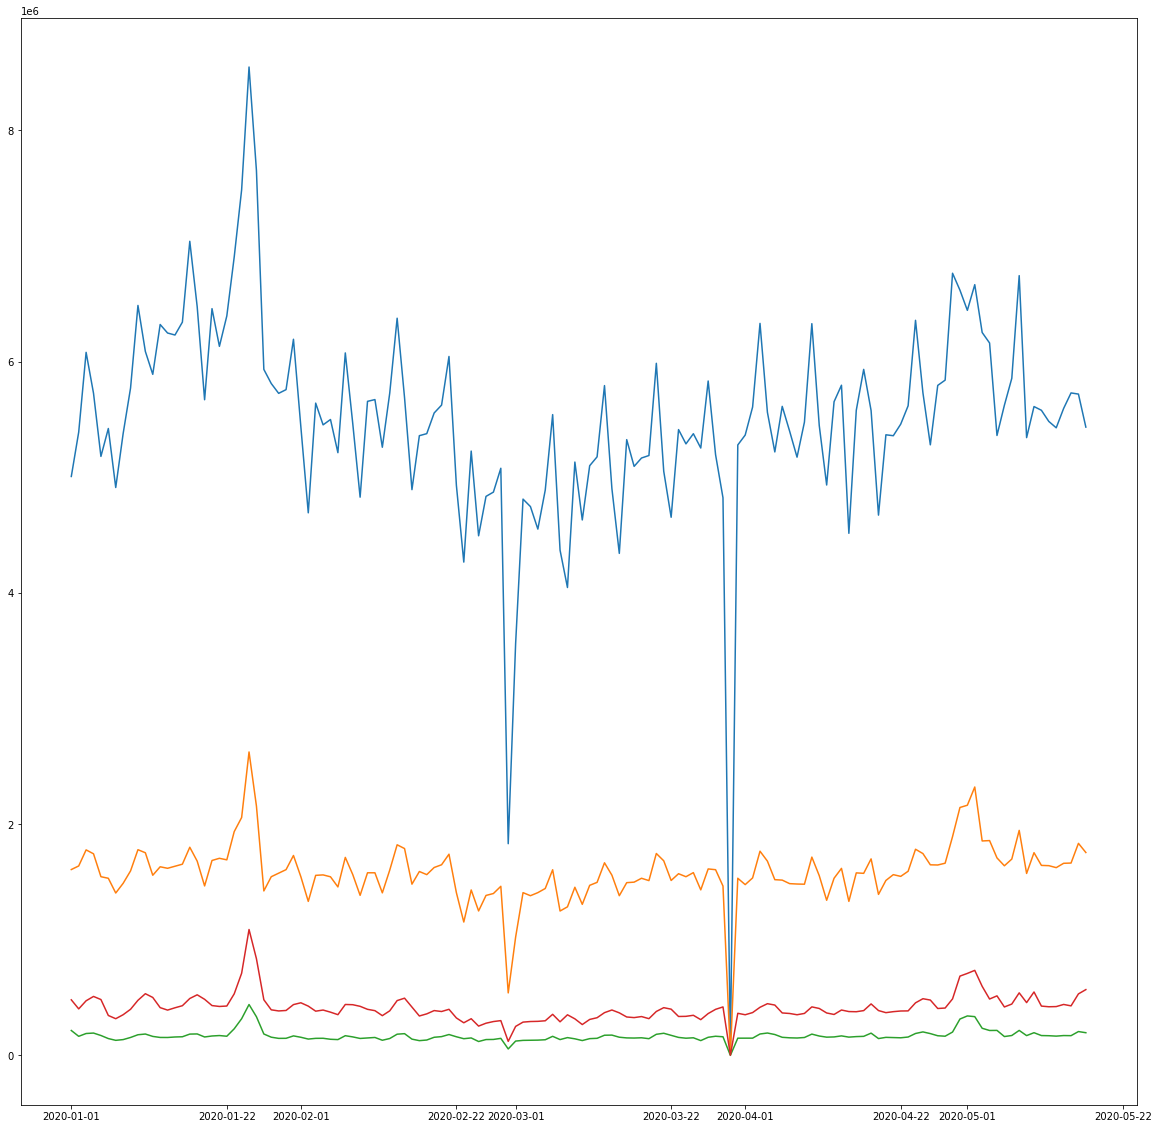

In [11]:
import matplotlib.pyplot as plt


plt.figure(figsize=(20, 20))
for col in per_date.columns[1:5]:
    plt.plot("날짜", col, data=per_date, label=col)

# cheak outliar

해당 일자를 확인한 결과 특정 시간대의 row가 존재하지 않음을 발견하였다. 이를 보간하기 위해 NA값으로 구성된 row를 추가해줬다.

In [12]:
train_df[train_df["날짜"] == 20200229]

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
1416,20200229,0,70783,12481,1074,2920,1020,956,26231,677,1538,1264,12739,2632,4420,2020,5216,9242,1399,4006,17911,19245,6522,2564,1655,649,33515,613,2540,7873,5389,1026,3447,401,1706,1381,1872
1417,20200229,1,51754,8195,694,2141,617,703,19200,593,1224,1182,9213,2002,3347,1716,4172,6880,1096,3158,13492,14138,4941,1468,1075,567,22342,440,1545,5193,3925,866,2685,231,1240,1014,1428
1418,20200229,2,41031,7143,641,1936,597,595,14281,416,1127,935,7077,1872,3038,1710,3908,5830,913,2729,11316,11240,4552,1067,850,460,16738,372,1499,4047,2893,800,2313,237,1107,848,1307
1419,20200229,3,37688,7626,624,1742,420,500,13834,442,1249,1252,6565,1598,2881,1203,4085,5467,869,3477,10126,11589,4494,1109,785,586,14596,343,1424,3915,2283,636,2083,201,1257,807,1181
1420,20200229,4,46899,11199,781,2720,651,653,18429,609,1651,1236,7119,2281,3455,1668,4595,6909,1249,4582,11732,16410,5949,1820,1094,863,19631,442,2146,5882,2999,705,2737,391,1888,1163,1797
1421,20200229,5,80770,20795,1717,4251,1385,1018,38419,1110,2344,1422,11476,3601,4843,2867,6749,13788,3153,8670,15730,34010,11375,2411,1904,1527,54005,944,4123,13280,7195,912,3920,542,3485,2561,4000
1422,20200229,6,126497,35718,3163,6909,3872,1840,57764,1882,4335,1983,20971,4997,6889,4431,9901,24207,5710,14427,21414,55762,21321,4205,3587,3265,84433,2492,7496,19922,10239,1737,5548,895,7021,4730,8105
1423,20200229,7,156874,51431,4414,10409,5324,3191,72190,2940,6607,3434,31779,6462,8555,6317,14715,30339,5901,17341,26256,64036,33172,6197,6338,4227,88089,4516,10094,22121,11850,2424,7812,1407,10988,6980,11540
1424,20200229,8,189865,57387,5271,12740,5784,3666,100060,3474,7473,4234,39886,7702,9897,8178,18864,33339,6009,18842,30299,73396,36920,9958,8363,4464,94748,4062,10906,26327,15156,3405,10854,1697,11589,7241,12127
1425,20200229,9,229212,70651,7700,15575,7699,4894,110886,4191,9372,5591,51377,10538,13452,11898,24836,43816,8222,23023,38287,90570,45636,15229,10356,6143,118904,4950,12192,30064,16810,4651,13805,1932,11631,8396,14127


In [13]:
train_df[train_df["날짜"] == 20200330]

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
2125,20200330,0,38243,7403,585,1695,426,351,13476,430,1304,820,6079,1633,2967,1271,2338,5138,1004,2456,9490,8930,3668,1344,903,563,13389,330,1257,2574,2011,521,1662,139,950,761,1130
2126,20200330,1,20378,3927,313,1060,315,223,7095,287,729,505,3129,1031,1716,692,1484,2760,685,1546,5564,4805,2026,680,508,289,6331,149,746,1220,1040,348,980,83,602,358,685


## fill disappered rows

In [14]:
new_df = train_df
for i in range(13, 24):
    new_df = new_df.append({"날짜" : 20200229, "시간" : i}, ignore_index=True)

In [15]:
new_df[new_df["날짜"] == 20200229]

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
1416,20200229.0,0.0,70783.0,12481.0,1074.0,2920.0,1020.0,956.0,26231.0,677.0,1538.0,1264.0,12739.0,2632.0,4420.0,2020.0,5216.0,9242.0,1399.0,4006.0,17911.0,19245.0,6522.0,2564.0,1655.0,649.0,33515.0,613.0,2540.0,7873.0,5389.0,1026.0,3447.0,401.0,1706.0,1381.0,1872.0
1417,20200229.0,1.0,51754.0,8195.0,694.0,2141.0,617.0,703.0,19200.0,593.0,1224.0,1182.0,9213.0,2002.0,3347.0,1716.0,4172.0,6880.0,1096.0,3158.0,13492.0,14138.0,4941.0,1468.0,1075.0,567.0,22342.0,440.0,1545.0,5193.0,3925.0,866.0,2685.0,231.0,1240.0,1014.0,1428.0
1418,20200229.0,2.0,41031.0,7143.0,641.0,1936.0,597.0,595.0,14281.0,416.0,1127.0,935.0,7077.0,1872.0,3038.0,1710.0,3908.0,5830.0,913.0,2729.0,11316.0,11240.0,4552.0,1067.0,850.0,460.0,16738.0,372.0,1499.0,4047.0,2893.0,800.0,2313.0,237.0,1107.0,848.0,1307.0
1419,20200229.0,3.0,37688.0,7626.0,624.0,1742.0,420.0,500.0,13834.0,442.0,1249.0,1252.0,6565.0,1598.0,2881.0,1203.0,4085.0,5467.0,869.0,3477.0,10126.0,11589.0,4494.0,1109.0,785.0,586.0,14596.0,343.0,1424.0,3915.0,2283.0,636.0,2083.0,201.0,1257.0,807.0,1181.0
1420,20200229.0,4.0,46899.0,11199.0,781.0,2720.0,651.0,653.0,18429.0,609.0,1651.0,1236.0,7119.0,2281.0,3455.0,1668.0,4595.0,6909.0,1249.0,4582.0,11732.0,16410.0,5949.0,1820.0,1094.0,863.0,19631.0,442.0,2146.0,5882.0,2999.0,705.0,2737.0,391.0,1888.0,1163.0,1797.0
1421,20200229.0,5.0,80770.0,20795.0,1717.0,4251.0,1385.0,1018.0,38419.0,1110.0,2344.0,1422.0,11476.0,3601.0,4843.0,2867.0,6749.0,13788.0,3153.0,8670.0,15730.0,34010.0,11375.0,2411.0,1904.0,1527.0,54005.0,944.0,4123.0,13280.0,7195.0,912.0,3920.0,542.0,3485.0,2561.0,4000.0
1422,20200229.0,6.0,126497.0,35718.0,3163.0,6909.0,3872.0,1840.0,57764.0,1882.0,4335.0,1983.0,20971.0,4997.0,6889.0,4431.0,9901.0,24207.0,5710.0,14427.0,21414.0,55762.0,21321.0,4205.0,3587.0,3265.0,84433.0,2492.0,7496.0,19922.0,10239.0,1737.0,5548.0,895.0,7021.0,4730.0,8105.0
1423,20200229.0,7.0,156874.0,51431.0,4414.0,10409.0,5324.0,3191.0,72190.0,2940.0,6607.0,3434.0,31779.0,6462.0,8555.0,6317.0,14715.0,30339.0,5901.0,17341.0,26256.0,64036.0,33172.0,6197.0,6338.0,4227.0,88089.0,4516.0,10094.0,22121.0,11850.0,2424.0,7812.0,1407.0,10988.0,6980.0,11540.0
1424,20200229.0,8.0,189865.0,57387.0,5271.0,12740.0,5784.0,3666.0,100060.0,3474.0,7473.0,4234.0,39886.0,7702.0,9897.0,8178.0,18864.0,33339.0,6009.0,18842.0,30299.0,73396.0,36920.0,9958.0,8363.0,4464.0,94748.0,4062.0,10906.0,26327.0,15156.0,3405.0,10854.0,1697.0,11589.0,7241.0,12127.0
1425,20200229.0,9.0,229212.0,70651.0,7700.0,15575.0,7699.0,4894.0,110886.0,4191.0,9372.0,5591.0,51377.0,10538.0,13452.0,11898.0,24836.0,43816.0,8222.0,23023.0,38287.0,90570.0,45636.0,15229.0,10356.0,6143.0,118904.0,4950.0,12192.0,30064.0,16810.0,4651.0,13805.0,1932.0,11631.0,8396.0,14127.0


## Reorder by datetime

In [16]:
for i in range(2, 24):
    new_df = new_df.append({"날짜" : 20200330, "시간" : i}, ignore_index=True)

In [17]:
new_df[new_df["날짜"] == 20200330]

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
2125,20200330.0,0.0,38243.0,7403.0,585.0,1695.0,426.0,351.0,13476.0,430.0,1304.0,820.0,6079.0,1633.0,2967.0,1271.0,2338.0,5138.0,1004.0,2456.0,9490.0,8930.0,3668.0,1344.0,903.0,563.0,13389.0,330.0,1257.0,2574.0,2011.0,521.0,1662.0,139.0,950.0,761.0,1130.0
2126,20200330.0,1.0,20378.0,3927.0,313.0,1060.0,315.0,223.0,7095.0,287.0,729.0,505.0,3129.0,1031.0,1716.0,692.0,1484.0,2760.0,685.0,1546.0,5564.0,4805.0,2026.0,680.0,508.0,289.0,6331.0,149.0,746.0,1220.0,1040.0,348.0,980.0,83.0,602.0,358.0,685.0
3290,20200330.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3291,20200330.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3292,20200330.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3293,20200330.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3294,20200330.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3295,20200330.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3296,20200330.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3297,20200330.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
new_df.sort_values(by=['날짜', '시간'], inplace=True, ignore_index=True)

In [19]:
new_df[new_df["날짜"] == 20200330]

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
2136,20200330.0,0.0,38243.0,7403.0,585.0,1695.0,426.0,351.0,13476.0,430.0,1304.0,820.0,6079.0,1633.0,2967.0,1271.0,2338.0,5138.0,1004.0,2456.0,9490.0,8930.0,3668.0,1344.0,903.0,563.0,13389.0,330.0,1257.0,2574.0,2011.0,521.0,1662.0,139.0,950.0,761.0,1130.0
2137,20200330.0,1.0,20378.0,3927.0,313.0,1060.0,315.0,223.0,7095.0,287.0,729.0,505.0,3129.0,1031.0,1716.0,692.0,1484.0,2760.0,685.0,1546.0,5564.0,4805.0,2026.0,680.0,508.0,289.0,6331.0,149.0,746.0,1220.0,1040.0,348.0,980.0,83.0,602.0,358.0,685.0
2138,20200330.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2139,20200330.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2140,20200330.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2141,20200330.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2142,20200330.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2143,20200330.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2144,20200330.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2145,20200330.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# NA값을 그대로 둘 df 저장
null_df = new_df.copy()

제대로 된 위치에 NA값이 생긴것을 확인했다.

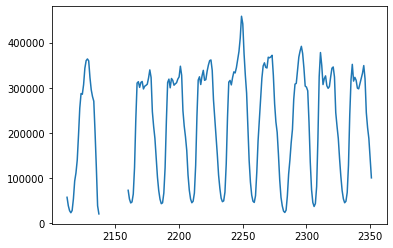

In [21]:
plt.plot(new_df[(new_df['날짜'] > 20200328) & (new_df['날짜'] < 20200408)]['10'])

## Make datetime col

시간 정보를 담은 col이 2개라서 데이터 처리에 불편하다. 편의를 위해 이를 통합해주었다

In [22]:
new_df['날짜'] = new_df["날짜"].astype('int')
new_df['시간'] = new_df["시간"].astype('int')
new_df['datetime'] = new_df["날짜"] * 100 + new_df["시간"]

In [23]:
new_df['datetime'] = pd.to_datetime(new_df['datetime'], format="%Y%m%d%H")

In [24]:
new_col = list(new_df.columns[:-1])

In [25]:
new_col.insert(0, 'datetime')

In [26]:
new_df = new_df[new_col]

In [27]:
new_df

,datetime,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,2020-01-01 00:00:00,20200101,0,83247.0,19128.0,2611.0,5161.0,1588.0,892.0,32263.0,1636.0,7938.0,1894.0,14957.0,3527.0,11174.0,2930.0,8640.0,14175.0,2035.0,5231.0,18492.0,48520.0,15393.0,16628.0,8804.0,2790.0,38657.0,1311.0,3482.0,11299.0,7072.0,1176.0,3810.0,748.0,3920.0,2133.0,3799.0
1,2020-01-01 01:00:00,20200101,1,89309.0,19027.0,3337.0,5502.0,1650.0,1043.0,35609.0,1644.0,9896.0,1967.0,14682.0,3420.0,13884.0,3062.0,8349.0,15654.0,2417.0,5483.0,15283.0,57904.0,15834.0,19785.0,8483.0,3381.0,45759.0,1162.0,3849.0,13180.0,8771.0,1283.0,3763.0,782.0,3483.0,2057.0,4010.0
2,2020-01-01 02:00:00,20200101,2,66611.0,14710.0,2970.0,4631.0,1044.0,921.0,26821.0,1104.0,9343.0,1838.0,11120.0,3587.0,17141.0,3255.0,7025.0,12520.0,1859.0,5058.0,14327.0,53876.0,13866.0,24501.0,8167.0,2670.0,27425.0,768.0,2299.0,7986.0,5426.0,1536.0,3229.0,491.0,2634.0,1526.0,3388.0
3,2020-01-01 03:00:00,20200101,3,53290.0,13753.0,2270.0,4242.0,1021.0,790.0,21322.0,909.0,10009.0,1630.0,9836.0,3842.0,20715.0,2661.0,7226.0,9821.0,1724.0,4863.0,12787.0,51615.0,13528.0,28695.0,9459.0,2325.0,18893.0,632.0,1716.0,5703.0,3156.0,1104.0,2882.0,431.0,2488.0,1268.0,3686.0
4,2020-01-01 04:00:00,20200101,4,52095.0,17615.0,2406.0,3689.0,1840.0,922.0,22711.0,1354.0,15497.0,1264.0,10668.0,4559.0,28308.0,2894.0,8201.0,9038.0,960.0,5166.0,11479.0,47424.0,18156.0,26977.0,10944.0,3583.0,18135.0,875.0,2421.0,5816.0,2933.0,1206.0,2433.0,499.0,2952.0,1927.0,5608.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3307,2020-05-17 19:00:00,20200517,19,311727.0,101285.0,10085.0,30637.0,10060.0,8749.0,148935.0,6801.0,26101.0,9370.0,74169.0,17764.0,34715.0,19806.0,42734.0,63382.0,14130.0,34866.0,71475.0,96849.0,79150.0,25109.0,14680.0,10465.0,128344.0,6726.0,15431.0,25597.0,14292.0,9300.0,22238.0,3786.0,16936.0,10729.0,20194.0
3308,2020-05-17 20:00:00,20200517,20,305354.0,91426.0,8607.0,26021.0,8095.0,7198.0,136503.0,6147.0,20759.0,8432.0,68923.0,14593.0,30279.0,17634.0,37661.0,57815.0,13055.0,31943.0,65378.0,92116.0,72379.0,23165.0,11879.0,9135.0,131682.0,5501.0,15378.0,24661.0,14747.0,8239.0,20604.0,3203.0,15018.0,9767.0,17962.0
3309,2020-05-17 21:00:00,20200517,21,306008.0,75113.0,6325.0,19933.0,5711.0,4494.0,129412.0,5134.0,14496.0,6739.0,54455.0,11997.0,27047.0,15943.0,29029.0,54627.0,12292.0,27424.0,60696.0,83628.0,57866.0,16629.0,8573.0,6488.0,127826.0,4216.0,12558.0,22781.0,14081.0,6392.0,17937.0,2447.0,12403.0,7825.0,14031.0
3310,2020-05-17 22:00:00,20200517,22,237447.0,49498.0,4209.0,12145.0,3891.0,2718.0,96698.0,3526.0,9363.0,4543.0,35618.0,7996.0,19478.0,10010.0,18663.0,39694.0,8818.0,17770.0,45983.0,57321.0,35250.0,10761.0,5331.0,4109.0,94288.0,2578.0,8870.0,16640.0,11066.0,4427.0,11955.0,1495.0,7507.0,5387.0,8889.0


In [28]:
dt_df = new_df.copy()

In [29]:
null_list = dt_df[dt_df['10'].isnull() == True].index

In [30]:
null_list

Int64Index([1429, 1430, 1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439,
            2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148,
            2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2159],
           dtype='int64')

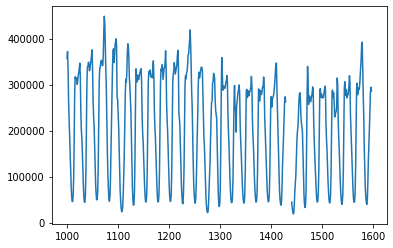

In [31]:
plt.plot(dt_df.loc[range(1000, 1429+24*7)]['10'])

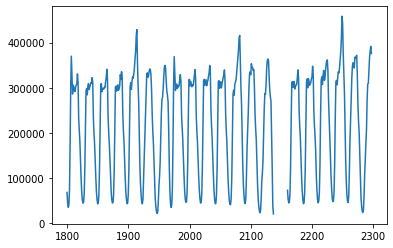

In [32]:
plt.plot(dt_df.loc[range(1800, 2130+24*7)]['10'])

In [33]:
dt_df = dt_df[dt_df.columns[3:]]

In [34]:
for i in range(len(null_list)):
    dt_df.loc[null_list[i]] = (dt_df.loc[null_list[i] - 24*7] + dt_df.loc[null_list[i] + 24*7]) / 2

In [35]:
dt_df.loc[null_list]

,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
1429,307829.5,94899.5,11998.5,23499.5,11019.5,7593.5,152707.5,6225.5,16445.5,8530.5,71848.5,17105.0,26561.5,19006.5,40282.0,61642.5,12560.0,30751.5,58416.0,131891.0,74029.0,41673.5,25857.0,9408.5,154202.0,6723.5,15401.0,38616.0,19408.5,7822.0,20948.0,2705.5,13727.5,11323.5,18745.0
1430,313070.0,101067.0,12855.5,24669.5,11499.0,7953.0,168638.0,6451.5,17050.5,8734.0,75492.5,17716.5,28434.0,20412.5,41531.0,65884.0,14015.0,31867.0,60708.0,136160.5,77258.5,41603.5,26885.5,9881.5,156327.5,6772.0,15826.0,39811.0,19193.5,8238.5,22709.5,2728.5,13381.0,11476.5,19365.5
1431,319125.5,101240.5,12649.0,24847.5,11176.0,7751.5,176688.0,6426.5,17289.5,8919.0,77161.5,17126.5,28559.0,21067.0,42867.5,69370.5,14046.0,32510.0,61646.0,136794.0,76900.0,40027.0,26475.5,9817.5,164301.5,6704.5,15535.0,35868.0,20310.0,8802.5,23700.5,2903.5,13492.5,11977.0,20544.5
1432,322038.0,98761.0,12632.0,24269.0,11045.5,7904.5,174106.0,6589.5,17266.0,8858.5,75234.0,17089.0,27962.0,20560.5,40778.0,69229.0,14128.5,32007.0,61342.0,131259.5,75559.5,39150.5,24631.5,9413.0,171331.0,6941.0,15627.5,42663.5,21058.5,8502.0,23699.0,2954.5,13823.0,11989.0,20452.5
1433,314867.5,94107.5,11087.0,22162.0,10753.0,7453.0,151226.0,6341.5,17755.0,7939.5,69660.0,15574.5,24377.5,19053.5,38445.5,64415.5,13831.5,30960.0,55889.0,127249.5,72003.5,32780.5,22456.0,9349.5,172862.5,7067.5,14428.0,42555.0,21445.0,7702.5,22105.5,3061.5,14483.5,12162.0,20077.0
1434,262174.5,71619.0,8373.5,16942.5,8778.5,5862.5,126577.5,4896.5,13923.0,5943.5,56798.5,12143.5,18998.0,14445.0,30631.0,51272.5,10802.0,24587.0,46167.5,104413.0,56313.5,27132.0,16779.5,6743.5,145946.5,5009.5,11309.0,34618.0,18481.5,6136.5,16756.0,2369.5,11086.5,8852.0,15024.5
1435,207598.0,52544.0,5727.0,12117.0,6205.5,3826.0,97528.5,3717.5,9939.5,4305.0,43627.0,9090.0,14153.5,11038.0,21304.0,38536.0,8159.0,17294.0,36654.5,78946.0,40862.5,22119.0,11394.5,4649.5,113582.5,3480.0,9448.0,25045.0,14532.5,4934.0,12407.0,1529.5,7601.5,6489.0,10206.5
1436,175237.0,40885.0,4213.5,8444.5,4617.5,2853.5,82039.0,3001.0,7088.5,3625.0,35235.0,6783.0,10315.5,8059.5,16465.0,29148.0,6639.5,13125.5,29664.5,64030.0,31369.5,16849.0,8634.0,3622.5,99106.5,2843.0,8062.0,21655.5,13519.0,4019.0,10018.0,1152.0,5936.5,4950.0,7818.5
1437,153291.0,31995.0,2924.5,6112.0,3444.5,2013.0,64791.5,2376.0,5163.0,2670.0,27982.5,5265.0,7841.5,6046.5,11956.5,23555.0,4966.5,9724.5,23372.0,50833.0,23464.0,11640.0,5749.5,2582.5,89848.5,2121.5,6900.5,19660.5,12687.5,3052.5,7418.0,871.0,4084.0,4247.5,6283.5
1438,117586.5,22304.5,2079.0,4325.5,2550.5,1439.5,48891.0,1764.5,3560.0,1632.5,19604.0,3891.0,5447.0,4029.5,8505.5,15383.0,3570.5,6466.0,16535.0,34960.0,16221.0,7514.0,3659.5,1974.5,68176.0,1456.0,4739.0,14982.5,10900.5,1961.5,5444.0,593.5,3010.0,3034.0,4153.5


자연스럽게 채워진 모습

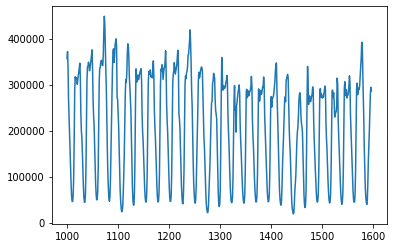

In [36]:
plt.plot(dt_df.loc[range(1000, 1429+24*7)]['10'])

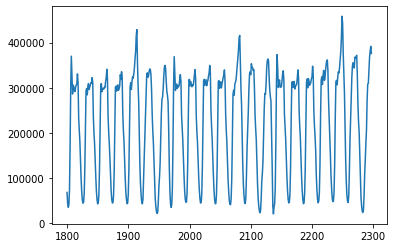

In [37]:
plt.plot(dt_df.loc[range(1800, 2130+24*7)]['10'])

## fill strange value

NA값을 채운 df정보를 확인한 결과 min값에 0이 있는것을 발견하였다. 정상적인 데이터가 아닌것 같으므로 확인해보자.

In [38]:
dt_df.describe()

,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
count,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000
mean,231774.360960,66692.371981,7145.146135,17315.006944,6635.043327,4681.629378,99352.511624,4392.436292,11381.987772,6257.640851,47539.062500,12453.929348,19743.344958,12237.845109,25998.067331,43265.836353,8049.290006,22538.632850,47893.692784,76572.624849,49355.802838,13976.907760,11093.299064,6503.057820,110517.508605,5145.136021,10919.598581,27186.110809,13932.073521,4867.869716,14632.781854,2457.060386,12097.736111,7953.286534,13959.630435
std,121764.714077,41570.504849,5559.502303,13285.723439,4777.545589,3524.502086,58345.674865,2849.745611,8702.956485,4235.401321,30096.552809,8697.073869,13858.320694,9067.262115,19424.289841,26518.032162,4873.196824,14409.828829,25918.593930,43763.210446,36947.069394,12871.420316,9473.504867,4839.042824,59167.156454,3866.265507,6159.773679,15582.299548,7113.579787,4069.398904,9552.009217,1870.920000,7986.932983,5204.042605,9264.169356
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,111976.500000,23516.000000,1910.750000,5209.250000,1703.750000,1319.750000,43261.500000,1536.000000,3207.000000,2341.250000,16713.000000,4594.000000,7779.500000,3559.500000,8455.750000,16000.500000,3105.250000,7786.250000,25041.750000,32870.750000,14013.250000,2950.250000,2487.250000,1783.000000,51063.250000,1310.750000,4529.000000,11611.250000,7331.500000,1498.750000,4988.250000,714.750000,3616.000000,2555.500000,3979.750000
50%,267087.000000,73882.000000,6939.500000,16634.000000,7009.500000,4691.500000,111781.000000,4751.500000,10783.500000,5916.500000,52158.000000,11668.000000,18175.000000,12279.000000,24995.000000,48987.000000,8748.500000,23969.500000,49095.500000,87998.000000,49907.000000,10518.000000,9728.000000,6659.000000,132432.000000,5146.000000,12872.000000,31119.500000,15904.750000,4245.500000,15925.000000,2200.000000,13469.500000,8559.000000,15144.500000
75%,326900.750000,99798.500000,10884.750000,25845.750000,10318.250000,6924.250000,140797.000000,6653.250000,16476.000000,9348.500000,69943.250000,18248.250000,28374.750000,18164.250000,37182.500000,64577.750000,12144.250000,34443.250000,67382.500000,109547.250000,73870.500000,20290.000000,16638.750000,9933.250000,160006.750000,8120.500000,16191.500000,39060.500000,19431.500000,6750.500000,21716.250000,3745.250000,18698.750000,12474.125000,22048.000000
max,580098.000000,200808.000000,45869.000000,114833.000000,24596.000000,24639.000000,292004.000000,14163.000000,48349.000000,33416.000000,165038.000000,56939.000000,99035.000000,53279.000000,131904.000000,118109.000000,19309.000000,74691.000000,153141.000000,215521.000000,239389.000000,67751.000000,58262.000000,37465.000000,224895.000000,21409.000000,25891.000000,76629.000000,35192.000000,28531.000000,45531.000000,10581.000000,38061.000000,21229.000000,36915.000000


In [39]:
dt_df[dt_df['10'] < 1000]

,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
882,0.0,86.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,5.0,49.0,0.0,0.0,4.0,0.0,0.0,0.0,35.0,0.0,0.0
3245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


확인결과 2개의 row가 비정상적인 값을 지니고 있음을 알게 되었다. 직전 / 직후 시간의 평균값으로 대체하였다.

In [40]:
dt_df.loc[882] = (dt_df.loc[881] + dt_df.loc[883]) / 2
dt_df.loc[3245] = (dt_df.loc[3244] + dt_df.loc[3246]) / 2

In [41]:
# Null dataframe은 해당 row를 Null 값으로 대체
null_df = null_df.drop([882, 3245])

In [42]:
null_df = null_df.append({"날짜" : 20200206, "시간" : 18}, ignore_index=True)
null_df = null_df.append({"날짜" : 20200515, "시간" : 5}, ignore_index=True)

In [43]:
null_df.sort_values(by=['날짜', '시간'], inplace=True, ignore_index=True)

In [44]:
null_df.iloc[[882, 3245]]

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
882,20200206.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3245,20200515.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
dt_df.describe()

,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
count,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000
mean,231907.048309,66729.576993,7148.314161,17323.354318,6638.119867,4683.803744,99402.580918,4394.844958,11387.287591,6260.977808,47562.889342,12460.041969,19753.491697,12243.417120,26010.343901,43286.325634,8053.377717,22549.842391,47921.667723,76612.125151,49379.622585,13981.200634,11097.708182,6506.247283,110586.830465,5147.941123,10926.112470,27204.822615,13941.964674,4869.688708,14640.403835,2458.628019,12105.974487,7958.330012,13967.699426
std,121651.040087,41543.329439,5557.374847,13280.370562,4775.500025,3523.073500,58301.478265,2848.118487,8699.419796,4233.184735,30079.132452,8692.738626,13851.205543,9063.394125,19416.329896,26499.407487,4869.486313,14400.031996,25896.386007,43727.715641,36930.875265,12868.353659,9470.488555,4836.690973,59111.716802,3864.753971,6154.323472,15570.893336,7106.850008,4068.065892,9546.677779,1870.497941,7982.947423,5201.078696,9258.913694
min,18729.000000,3927.000000,313.000000,937.000000,229.000000,197.000000,7095.000000,222.000000,55.000000,300.000000,3129.000000,763.000000,1176.000000,491.000000,1484.000000,2415.000000,388.000000,1194.000000,3108.000000,4805.000000,2026.000000,530.000000,492.000000,289.000000,6331.000000,149.000000,746.000000,1220.000000,1040.000000,246.000000,701.000000,45.000000,581.000000,358.000000,685.000000
25%,112291.250000,23563.750000,1913.000000,5226.500000,1706.250000,1328.000000,43342.500000,1541.250000,3208.500000,2346.250000,16727.750000,4605.500000,7789.250000,3562.000000,8479.750000,16032.250000,3111.500000,7812.500000,25093.250000,33056.750000,14046.500000,2958.750000,2502.500000,1788.000000,51267.500000,1311.750000,4544.000000,11649.250000,7361.000000,1503.500000,4997.250000,717.500000,3620.000000,2560.500000,3989.000000
50%,267170.500000,73921.000000,6947.500000,16645.500000,7021.500000,4703.000000,111840.500000,4757.000000,10793.000000,5921.000000,52175.500000,11674.500000,18177.000000,12282.000000,25030.000000,48987.000000,8748.500000,23969.500000,49113.000000,88092.500000,49997.000000,10521.500000,9752.500000,6677.000000,132476.000000,5154.500000,12878.500000,31122.000000,15916.500000,4253.000000,15928.500000,2201.500000,13486.750000,8567.500000,15163.000000
75%,326900.750000,99798.500000,10884.750000,25845.750000,10318.250000,6924.250000,140797.000000,6653.250000,16476.000000,9348.500000,69943.250000,18248.250000,28374.750000,18164.250000,37182.500000,64577.750000,12144.250000,34443.250000,67382.500000,109547.250000,73870.500000,20290.000000,16638.750000,9933.250000,160006.750000,8120.500000,16191.500000,39063.250000,19436.750000,6750.500000,21716.250000,3746.250000,18701.500000,12474.125000,22048.000000
max,580098.000000,200808.000000,45869.000000,114833.000000,24596.000000,24639.000000,292004.000000,14163.000000,48349.000000,33416.000000,165038.000000,56939.000000,99035.000000,53279.000000,131904.000000,118109.000000,19309.000000,74691.000000,153141.000000,215521.000000,239389.000000,67751.000000,58262.000000,37465.000000,224895.000000,21409.000000,25891.000000,76629.000000,35192.000000,28531.000000,45531.000000,10581.000000,38061.000000,21229.000000,36915.000000


## fix validation data

복붙놀이를 하다보니 예측에 사용되는 data에도 이상치가 있는것을 확인하였다.<br>
이를 고치기 위해 직전 3주의 data를 모니터링 해보았고,<br>
* 1안 : 시간대별 증감 비율 평균
* 2안 : 시간대별 증감 절대값 평균
* 3안 : 시간대별 증감 회귀곡선
* 4안 : 시간대별 증감 비율(직전주)
* 5안 : 시간대별 증감 절대값(직전주)

정도를 고려해 봤는데, 결국 4번째 안건이 다른 시기의 데이터에 적용했을 때 오차가 가장 적어서 이 방법을 택했다.

문제의 데이터는 vaiildation data 기준 251 ~ 253 index의 row이다.<br>
다만 다른 데이터들과 비교했을 때, 해당 row 전후의 250, 254 row들의 값의 양상도 달랐기 때문에 이들도 변경해줘야한다고 판단했다.

In [46]:
validation_df[(validation_df['시간'] < 16) & (validation_df['시간'] > 8) & (validation_df['날짜'] == 20200521)]

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
249,20200521,9,321981,101842,10269,27726,11048,6978,155996,6323,15972,8336,69338,16100,25201,19222,33538,71229,13886,41482,63216,103460,77514,14087,14973,9728,159884,7560,17388,35914,19875,5927,23000,2433,20816,13748,22349
250,20200521,10,343667,107261,2942,21563,2881,1831,140808,7163,17779,10082,41336,8805,31776,20506,38214,74439,12688,44438,73441,112303,86261,18560,16709,11716,156349,9071,17838,33240,18792,7137,23833,2246,21369,14187,23894
251,20200521,11,339887,99234,0,19127,0,0,140396,6696,17574,10795,28991,5549,34215,19625,40070,72799,13283,43235,76758,108672,82784,19970,17758,11140,146808,7853,17197,29479,18025,7938,22988,2045,20082,13671,22567
252,20200521,12,322724,94243,0,16294,0,0,138321,6241,16659,9169,25061,5119,30711,17176,36812,66742,13299,38411,72243,101047,76343,20934,17346,10337,139759,6034,16643,27321,17244,7317,20898,2125,16320,11651,19487
253,20200521,13,329873,93115,0,16674,0,0,137759,6276,16384,9279,27200,5424,27842,18269,37873,62039,12864,38264,70970,99667,78441,21897,18030,9923,148588,6709,17356,29011,18653,7241,21368,2206,18046,12433,19496
254,20200521,14,334335,101138,7225,24275,6751,4802,149134,6716,17645,9427,55234,13798,30310,19473,39562,67227,15080,41066,73779,105869,84526,22942,19125,10239,158742,7698,17587,33825,19185,7900,21934,2359,18697,13151,21906
255,20200521,15,347699,107829,12495,30297,10466,8501,153721,6923,18046,9987,75239,19689,32150,20722,40636,68661,14469,40978,73787,109283,86438,23215,19244,10018,165470,8308,17205,29813,19964,8259,22285,2296,18462,13428,21927


In [47]:
train_df[(train_df['시간'] < 16) & (train_df['시간'] > 8) & (train_df['날짜'] == 20200430)]

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
2856,20200430,9,379699,137409,18038,42007,12158,11730,196802,8685,23751,15523,102727,35729,46974,32662,77534,102757,13434,45707,100496,157220,122854,34985,24775,12222,147971,13177,18095,50033,16423,17073,35928,5433,18015,14650,26947
2857,20200430,10,413710,154569,25204,57741,15523,16391,220670,10198,31336,19831,124225,43744,58371,42134,93296,118109,14198,51816,111475,168469,147294,38859,29429,19103,155488,13856,20182,54601,17671,20793,39822,7057,21098,18046,32633
2858,20200430,11,415982,165250,26946,60431,17470,19356,227627,10856,33825,21743,125311,44833,65365,46002,100393,103045,13582,50736,109282,173715,162252,41193,34168,21457,160769,13486,21163,57191,18315,19679,39615,8033,19937,19928,35276
2859,20200430,12,405263,156443,23503,58505,17193,16344,227209,10887,33614,19455,116887,41710,62662,44441,95471,74864,15142,48070,107987,170093,153020,43093,34197,19998,156530,14367,19221,53049,16577,20230,36700,7253,18115,18795,28861
2860,20200430,13,401781,157156,22807,56159,17515,14864,217992,10715,32630,18938,110438,41598,62234,35587,93188,76852,14573,48095,107968,165445,148307,46079,34837,18879,155528,13370,18559,49718,17660,21212,35085,6809,16252,17466,25990
2861,20200430,14,390018,153512,23365,54367,18062,14927,221642,10128,32254,19187,112049,41579,67410,38106,98895,78771,16661,50918,108324,176393,159071,48132,37881,18980,161145,13006,17875,54305,18134,20871,33799,6729,16345,16386,28258
2862,20200430,15,397703,145924,25732,51151,18305,15796,231587,9822,30830,18954,113564,43755,65525,40197,98295,88082,16989,51423,107360,177434,161295,50839,40667,18205,167169,10546,18357,45983,18443,21809,35615,6576,16219,15736,28890


In [48]:
train_df[(train_df['시간'] < 16) & (train_df['시간'] > 8) & (train_df['날짜'] == 20200507)]

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
3024,20200507,9,324631,100114,10546,26870,10303,7459,137904,6830,15840,8319,67646,14742,25512,19793,33165,69660,14057,39588,61745,108596,78730,13191,15607,9406,171071,8546,17582,55654,21238,6567,22251,3744,20179,13802,23472
3025,20200507,10,346218,113520,11957,31406,10546,8055,154870,7250,17899,10245,74494,17587,31578,22312,38584,73417,15633,43541,73127,118305,83263,17827,17428,11538,161959,10153,17985,51367,19494,7277,24025,3603,20663,14704,24718
3026,20200507,11,337672,111826,12146,30898,10246,7370,172200,7234,18377,11204,74771,19183,33110,22274,39151,73486,15098,42651,77812,116032,74099,19229,17990,11684,149492,9338,16874,49289,19457,7866,23345,3397,18959,13363,22493
3027,20200507,12,329394,101678,11129,27536,9527,6586,164224,6554,15945,9820,66449,17885,29981,20778,36309,69592,13606,38868,77006,106767,66428,19605,16774,10217,148498,7507,15863,45688,18486,7398,22350,2918,16962,11406,20155
3028,20200507,13,326511,100585,11668,28370,10809,6906,167245,6509,16731,9896,70564,17594,30129,21709,37923,69627,14191,37437,73955,107753,68942,19928,18181,9261,154324,7317,17344,47700,19583,7729,22441,3435,17562,12643,20760
3029,20200507,14,337056,104859,11875,29865,10869,7593,171655,7262,17888,10195,75965,19327,29572,23260,38960,71750,14417,39758,73369,114531,71843,20822,19241,10002,162771,8754,17179,47705,20098,8684,23204,3752,19368,13481,22413
3030,20200507,15,349749,107517,12421,31446,10619,8084,181418,7069,17746,9529,76640,18821,30672,26827,39981,73237,15436,38499,74739,113486,73290,20762,19226,10132,168432,9555,18025,45744,20699,8177,24169,3338,19147,13876,23405


In [49]:
validation_df[(validation_df['시간'] < 16) & (validation_df['시간'] > 8) & (validation_df['날짜'] == 20200514)]

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
81,20200514,9,309853,97371,11236,29026,9897,7154,134412,6582,16482,8470,70048,15061,25703,18186,33051,60939,14202,39947,62340,100732,73164,14620,15232,10470,169707,8285,16267,40519,19418,5780,23683,3850,11837,13543,22049
82,20200514,10,327504,107195,12158,31267,10563,7479,145116,6923,17782,10262,77616,18576,30997,19128,39173,65402,15510,42627,68681,109377,80255,18234,17006,11089,165546,8946,17592,38144,18843,7040,24639,3724,20532,14182,23750
83,20200514,11,329581,105289,11997,30162,9658,7347,146566,7031,18227,10758,74413,19750,32743,20200,39520,71507,14699,40497,68360,108469,77590,21536,17918,11863,152241,8617,16933,33861,18899,7377,23826,3342,18425,13235,21962
84,20200514,12,305018,99109,10908,26323,9112,6607,138360,6214,16701,9694,66739,18502,30554,17373,36070,67578,13605,36805,65537,98212,70946,21596,17819,10162,144400,6532,15205,32323,17947,6736,21200,2984,16081,11419,19574
85,20200514,13,301024,96818,11637,28274,9847,6771,142440,6364,16606,9844,71456,17934,29375,18476,38915,67253,13956,37018,70084,97226,76325,22208,19160,10281,153561,7454,16365,32985,18561,7250,21906,3455,18050,12030,20372
86,20200514,14,317092,100349,12018,29710,10760,7948,152330,6888,18200,9643,74160,18004,31223,20826,40088,69740,14489,37678,71609,105049,79707,22332,19743,11451,162511,8007,16881,37058,20033,7340,22810,3556,19148,13521,21838
87,20200514,15,329193,102402,12111,29537,10076,7594,153327,7072,17254,9449,77866,18074,32248,23388,40983,70503,14955,38712,73117,106049,80616,21293,18983,10275,167871,8921,16264,32932,20185,8169,23095,3484,18748,12955,22048


In [50]:
null_val_df = validation_df.copy()

In [51]:
cols = ['101', '121', '140']
for col in cols:
    validation_df.loc[250][col] = validation_df.loc[249][col] * (validation_df.loc[82][col] / validation_df.loc[81][col])
    validation_df.loc[251][col] = validation_df.loc[250][col] * (validation_df.loc[83][col] / validation_df.loc[82][col])
    validation_df.loc[252][col] = validation_df.loc[251][col] * (validation_df.loc[84][col] / validation_df.loc[83][col])
    validation_df.loc[253][col] = validation_df.loc[252][col] * (validation_df.loc[85][col] / validation_df.loc[84][col])
    validation_df.loc[254][col] = validation_df.loc[253][col] * (validation_df.loc[86][col] / validation_df.loc[85][col])

In [52]:
for col in cols:
    null_val_df.loc[250, col] = np.NAN
    null_val_df.loc[251, col] = np.NAN
    null_val_df.loc[252, col] = np.NAN
    null_val_df.loc[253, col] = np.NAN
    null_val_df.loc[254, col] = np.NAN

In [53]:
validation_df[(validation_df['시간'] < 16) & (validation_df['시간'] > 8) & (validation_df['날짜'] == 20200521)]

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
249,20200521,9,321981,101842,10269,27726,11048,6978,155996,6323,15972,8336,69338,16100,25201,19222,33538,71229,13886,41482,63216,103460,77514,14087,14973,9728,159884,7560,17388,35914,19875,5927,23000,2433,20816,13748,22349
250,20200521,10,343667,107261,11111,21563,11791,7295,140808,7163,17779,10082,41336,8805,31776,20506,38214,74439,12688,44438,73441,112303,86261,18560,16709,11716,156349,9071,17838,33240,18792,7137,23833,2246,21369,14187,23894
251,20200521,11,339887,99234,10963,19127,10780,7166,140396,6696,17574,10795,28991,5549,34215,19625,40070,72799,13283,43235,76758,108672,82784,19970,17758,11140,146808,7853,17197,29479,18025,7938,22988,2045,20082,13671,22567
252,20200521,12,322724,94243,9967,16294,10170,6444,138321,6241,16659,9169,25061,5119,30711,17176,36812,66742,13299,38411,72243,101047,76343,20934,17346,10337,139759,6034,16643,27321,17244,7317,20898,2125,16320,11651,19487
253,20200521,13,329873,93115,10633,16674,10990,6603,137759,6276,16384,9279,27200,5424,27842,18269,37873,62039,12864,38264,70970,99667,78441,21897,18030,9923,148588,6709,17356,29011,18653,7241,21368,2206,18046,12433,19496
254,20200521,14,334335,101138,10981,24275,12008,7750,149134,6716,17645,9427,55234,13798,30310,19473,39562,67227,15080,41066,73779,105869,84526,22942,19125,10239,158742,7698,17587,33825,19185,7900,21934,2359,18697,13151,21906
255,20200521,15,347699,107829,12495,30297,10466,8501,153721,6923,18046,9987,75239,19689,32150,20722,40636,68661,14469,40978,73787,109283,86438,23215,19244,10018,165470,8308,17205,29813,19964,8259,22285,2296,18462,13428,21927


In [54]:
null_val_df[(null_val_df['시간'] < 16) & (null_val_df['시간'] > 8) & (null_val_df['날짜'] == 20200521)]

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
249,20200521,9,321981,101842,10269.0,27726,11048.0,6978.0,155996,6323,15972,8336,69338,16100,25201,19222,33538,71229,13886,41482,63216,103460,77514,14087,14973,9728,159884,7560,17388,35914,19875,5927,23000,2433,20816,13748,22349
250,20200521,10,343667,107261,NaN,21563,NaN,NaN,140808,7163,17779,10082,41336,8805,31776,20506,38214,74439,12688,44438,73441,112303,86261,18560,16709,11716,156349,9071,17838,33240,18792,7137,23833,2246,21369,14187,23894
251,20200521,11,339887,99234,NaN,19127,NaN,NaN,140396,6696,17574,10795,28991,5549,34215,19625,40070,72799,13283,43235,76758,108672,82784,19970,17758,11140,146808,7853,17197,29479,18025,7938,22988,2045,20082,13671,22567
252,20200521,12,322724,94243,NaN,16294,NaN,NaN,138321,6241,16659,9169,25061,5119,30711,17176,36812,66742,13299,38411,72243,101047,76343,20934,17346,10337,139759,6034,16643,27321,17244,7317,20898,2125,16320,11651,19487
253,20200521,13,329873,93115,NaN,16674,NaN,NaN,137759,6276,16384,9279,27200,5424,27842,18269,37873,62039,12864,38264,70970,99667,78441,21897,18030,9923,148588,6709,17356,29011,18653,7241,21368,2206,18046,12433,19496
254,20200521,14,334335,101138,NaN,24275,NaN,NaN,149134,6716,17645,9427,55234,13798,30310,19473,39562,67227,15080,41066,73779,105869,84526,22942,19125,10239,158742,7698,17587,33825,19185,7900,21934,2359,18697,13151,21906
255,20200521,15,347699,107829,12495.0,30297,10466.0,8501.0,153721,6923,18046,9987,75239,19689,32150,20722,40636,68661,14469,40978,73787,109283,86438,23215,19244,10018,165470,8308,17205,29813,19964,8259,22285,2296,18462,13428,21927


In [55]:
# train_data의 20200515 5시 데이터 추가
for col in validation_df.columns[2:]:
    validation_df.iloc[101][col] = dt_df.iloc[3245][col]

In [56]:
null_val_df.iloc[101] = null_df.iloc[3245]

test data에 대해서도 같은 작업을 수행해 주었다.

In [58]:
null_test_df = test_df.copy()

In [59]:
test_df[(test_df['시간'] < 16) & (test_df['시간'] > 8) & (test_df['날짜'] == 20200521)]

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
81,20200521,9,321981,101842,10269,27726,11048,6978,155996,6323,15972,8336,69338,16100,25201,19222,33538,71229,13886,41482,63216,103460,77514,14087,14973,9728,159884,7560,17388,35914,19875,5927,23000,2433,20816,13748,22349
82,20200521,10,343667,107261,2942,21563,2881,1831,140808,7163,17779,10082,41336,8805,31776,20506,38214,74439,12688,44438,73441,112303,86261,18560,16709,11716,156349,9071,17838,33240,18792,7137,23833,2246,21369,14187,23894
83,20200521,11,339887,99234,0,19127,0,0,140396,6696,17574,10795,28991,5549,34215,19625,40070,72799,13283,43235,76758,108672,82784,19970,17758,11140,146808,7853,17197,29479,18025,7938,22988,2045,20082,13671,22567
84,20200521,12,322724,94243,0,16294,0,0,138321,6241,16659,9169,25061,5119,30711,17176,36812,66742,13299,38411,72243,101047,76343,20934,17346,10337,139759,6034,16643,27321,17244,7317,20898,2125,16320,11651,19487
85,20200521,13,329873,93115,0,16674,0,0,137759,6276,16384,9279,27200,5424,27842,18269,37873,62039,12864,38264,70970,99667,78441,21897,18030,9923,148588,6709,17356,29011,18653,7241,21368,2206,18046,12433,19496
86,20200521,14,334335,101138,7225,24275,6751,4802,149134,6716,17645,9427,55234,13798,30310,19473,39562,67227,15080,41066,73779,105869,84526,22942,19125,10239,158742,7698,17587,33825,19185,7900,21934,2359,18697,13151,21906
87,20200521,15,347699,107829,12495,30297,10466,8501,153721,6923,18046,9987,75239,19689,32150,20722,40636,68661,14469,40978,73787,109283,86438,23215,19244,10018,165470,8308,17205,29813,19964,8259,22285,2296,18462,13428,21927


In [60]:
cols = ['101', '121', '140']
for col in cols:
    test_df.loc[82][col] = validation_df.loc[249][col] * (validation_df.loc[82][col] / validation_df.loc[81][col])
    test_df.loc[83][col] = validation_df.loc[250][col] * (validation_df.loc[83][col] / validation_df.loc[82][col])
    test_df.loc[84][col] = validation_df.loc[251][col] * (validation_df.loc[84][col] / validation_df.loc[83][col])
    test_df.loc[85][col] = validation_df.loc[252][col] * (validation_df.loc[85][col] / validation_df.loc[84][col])
    test_df.loc[86][col] = validation_df.loc[253][col] * (validation_df.loc[86][col] / validation_df.loc[85][col])

In [61]:
for col in cols:
    null_test_df.loc[82, col] = np.NAN
    null_test_df.loc[83, col] = np.NAN
    null_test_df.loc[84, col] = np.NAN
    null_test_df.loc[85, col] = np.NAN
    null_test_df.loc[86, col] = np.NAN

In [62]:
test_df[(test_df['시간'] < 16) & (test_df['시간'] > 8) & (test_df['날짜'] == 20200521)]

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
81,20200521,9,321981,101842,10269,27726,11048,6978,155996,6323,15972,8336,69338,16100,25201,19222,33538,71229,13886,41482,63216,103460,77514,14087,14973,9728,159884,7560,17388,35914,19875,5927,23000,2433,20816,13748,22349
82,20200521,10,343667,107261,11111,21563,11791,7295,140808,7163,17779,10082,41336,8805,31776,20506,38214,74439,12688,44438,73441,112303,86261,18560,16709,11716,156349,9071,17838,33240,18792,7137,23833,2246,21369,14187,23894
83,20200521,11,339887,99234,10963,19127,10780,7166,140396,6696,17574,10795,28991,5549,34215,19625,40070,72799,13283,43235,76758,108672,82784,19970,17758,11140,146808,7853,17197,29479,18025,7938,22988,2045,20082,13671,22567
84,20200521,12,322724,94243,9967,16294,10170,6444,138321,6241,16659,9169,25061,5119,30711,17176,36812,66742,13299,38411,72243,101047,76343,20934,17346,10337,139759,6034,16643,27321,17244,7317,20898,2125,16320,11651,19487
85,20200521,13,329873,93115,10633,16674,10990,6603,137759,6276,16384,9279,27200,5424,27842,18269,37873,62039,12864,38264,70970,99667,78441,21897,18030,9923,148588,6709,17356,29011,18653,7241,21368,2206,18046,12433,19496
86,20200521,14,334335,101138,10981,24275,12008,7750,149134,6716,17645,9427,55234,13798,30310,19473,39562,67227,15080,41066,73779,105869,84526,22942,19125,10239,158742,7698,17587,33825,19185,7900,21934,2359,18697,13151,21906
87,20200521,15,347699,107829,12495,30297,10466,8501,153721,6923,18046,9987,75239,19689,32150,20722,40636,68661,14469,40978,73787,109283,86438,23215,19244,10018,165470,8308,17205,29813,19964,8259,22285,2296,18462,13428,21927


In [63]:
null_test_df[(null_test_df['시간'] < 16) & (null_test_df['시간'] > 8) & (null_test_df['날짜'] == 20200521)]

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
81,20200521,9,321981,101842,10269.0,27726,11048.0,6978.0,155996,6323,15972,8336,69338,16100,25201,19222,33538,71229,13886,41482,63216,103460,77514,14087,14973,9728,159884,7560,17388,35914,19875,5927,23000,2433,20816,13748,22349
82,20200521,10,343667,107261,NaN,21563,NaN,NaN,140808,7163,17779,10082,41336,8805,31776,20506,38214,74439,12688,44438,73441,112303,86261,18560,16709,11716,156349,9071,17838,33240,18792,7137,23833,2246,21369,14187,23894
83,20200521,11,339887,99234,NaN,19127,NaN,NaN,140396,6696,17574,10795,28991,5549,34215,19625,40070,72799,13283,43235,76758,108672,82784,19970,17758,11140,146808,7853,17197,29479,18025,7938,22988,2045,20082,13671,22567
84,20200521,12,322724,94243,NaN,16294,NaN,NaN,138321,6241,16659,9169,25061,5119,30711,17176,36812,66742,13299,38411,72243,101047,76343,20934,17346,10337,139759,6034,16643,27321,17244,7317,20898,2125,16320,11651,19487
85,20200521,13,329873,93115,NaN,16674,NaN,NaN,137759,6276,16384,9279,27200,5424,27842,18269,37873,62039,12864,38264,70970,99667,78441,21897,18030,9923,148588,6709,17356,29011,18653,7241,21368,2206,18046,12433,19496
86,20200521,14,334335,101138,NaN,24275,NaN,NaN,149134,6716,17645,9427,55234,13798,30310,19473,39562,67227,15080,41066,73779,105869,84526,22942,19125,10239,158742,7698,17587,33825,19185,7900,21934,2359,18697,13151,21906
87,20200521,15,347699,107829,12495.0,30297,10466.0,8501.0,153721,6923,18046,9987,75239,19689,32150,20722,40636,68661,14469,40978,73787,109283,86438,23215,19244,10018,165470,8308,17205,29813,19964,8259,22285,2296,18462,13428,21927


In [64]:
validation_df.describe()

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
count,3.360000e+02,336.00000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000
mean,2.020052e+07,11.50000,235734.360119,71839.559524,7624.282738,19482.988095,7139.851190,5167.601190,102952.785714,4617.672619,12577.910714,6482.214286,49482.607143,12164.404762,21754.425595,13625.678571,26759.136905,46264.997024,9656.116071,25582.288690,50230.580357,74772.279762,53146.321429,14744.669643,11376.523810,6860.261905,116159.794643,5502.145833,12070.669643,25552.937500,14525.497024,5279.077381,16046.904762,2403.883929,13448.880952,8992.485119,15004.255952
std,4.037141e+00,6.93251,117244.374916,43023.743724,5275.836349,13014.826055,4867.558906,3560.963901,56225.600300,2858.986325,8815.479280,3883.624388,29707.884888,7473.092135,13124.115340,9503.799154,17486.018063,26474.538548,5368.253270,15686.351776,25035.367727,40571.242648,35319.767240,12564.229576,8767.282698,4638.499054,58497.160784,3945.432342,6554.509402,13780.707223,7039.666538,3700.957795,9905.828791,1669.162005,8242.638049,5586.243114,9563.451696
min,2.020051e+07,0.00000,25263.000000,7113.000000,546.000000,1761.000000,392.000000,370.000000,11640.000000,428.000000,1309.000000,500.000000,4564.000000,1460.000000,2009.000000,1191.000000,2790.000000,3382.000000,699.000000,2058.000000,4903.000000,8062.000000,4080.000000,708.000000,598.000000,368.000000,11907.000000,322.000000,1313.000000,2574.000000,1931.000000,549.000000,1265.000000,94.000000,1136.000000,819.000000,1250.000000
25%,2.020051e+07,5.75000,125006.250000,26646.250000,2323.000000,6383.250000,2146.500000,1573.250000,50215.750000,1856.750000,4227.750000,2547.250000,19640.000000,4651.000000,9582.250000,4245.750000,9506.000000,20049.750000,4055.500000,8808.500000,28637.500000,33197.250000,17771.500000,3281.000000,2938.250000,2209.250000,58232.000000,1497.000000,5316.000000,11519.500000,8720.250000,1860.750000,5954.250000,795.000000,4511.500000,3311.250000,4696.000000
50%,2.020052e+07,11.50000,291569.500000,84219.500000,8216.000000,20308.000000,7857.000000,5608.000000,119572.000000,5062.000000,12700.000000,6659.000000,54844.500000,11710.000000,21417.500000,14184.000000,28689.000000,55962.000000,11623.000000,29915.000000,52669.500000,87746.500000,59388.000000,12052.500000,10133.500000,7481.000000,139548.500000,5640.000000,14996.500000,29671.000000,17037.500000,4891.000000,17802.500000,2363.500000,15901.500000,9662.500000,16447.000000
75%,2.020052e+07,17.25000,326878.250000,104994.750000,11626.250000,28508.250000,10925.500000,7542.250000,144746.250000,6806.250000,17532.000000,9688.000000,72845.500000,18004.000000,30927.000000,20035.750000,38779.500000,68597.750000,13991.750000,38424.000000,71031.750000,106114.250000,78515.750000,21679.750000,17548.500000,10276.500000,163404.000000,8689.750000,17698.500000,37066.500000,19961.750000,7417.000000,23388.750000,3497.500000,20104.250000,13849.250000,23266.250000
max,2.020052e+07,23.00000,439173.000000,150733.000000,19038.000000,53098.000000,17634.000000,14861.000000,226740.000000,10638.000000,35738.000000,14632.000000,105867.000000,30800.000000,54732.000000,48226.000000,71411.000000,89774.000000,18952.000000,57386.000000,103228.000000,150652.000000,127277.000000,52116.000000,34969.000000,16530.000000,198934.000000,15828.000000,21257.000000,48132.000000,26537.000000,15578.000000,36225.000000,6220.000000,29441.000000,19906.000000,31504.000000


In [65]:
test_df.iloc[range(len(test_df)//2)].describe()

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
count,1.680000e+02,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000
mean,2.020052e+07,11.500000,238748.250000,73083.892857,7744.952381,19617.803571,7265.904762,5193.714286,104727.291667,4670.982143,12787.994048,6506.053571,49183.095238,12240.654762,22061.238095,13754.101190,27295.625000,46483.958333,9669.446429,26434.815476,50863.107143,74421.785714,54852.833333,15221.244048,11562.619048,6979.863095,116486.755952,5604.761905,12191.916667,24968.803571,14767.636905,5405.226190,16078.047619,2204.369048,13579.363095,9153.250000,15214.184524
std,2.005979e+00,6.942881,119060.280011,44178.602676,5424.214248,13223.802840,4978.756066,3583.118640,57587.061337,2920.100904,9020.160254,3921.538743,29778.847596,7768.580707,13555.933229,10020.949179,18043.856137,26807.709995,5369.660943,16267.355869,25564.841794,40887.943205,36931.415433,13511.749529,9192.338681,4779.853756,58639.168499,4101.901741,6614.650282,13512.647628,7077.389254,3898.381437,10002.979606,1523.386283,8346.246743,5740.852704,9758.697882
min,2.020052e+07,0.000000,25263.000000,7113.000000,546.000000,1965.000000,408.000000,382.000000,11640.000000,438.000000,1309.000000,567.000000,4564.000000,1677.000000,2176.000000,1191.000000,3085.000000,3382.000000,699.000000,2058.000000,5057.000000,8062.000000,4080.000000,708.000000,598.000000,368.000000,11907.000000,322.000000,1313.000000,2574.000000,1931.000000,549.000000,1265.000000,94.000000,1136.000000,819.000000,1250.000000
25%,2.020052e+07,5.750000,125721.000000,28810.000000,2326.750000,6696.000000,2276.250000,1546.000000,50402.250000,1891.000000,4322.750000,2547.250000,20048.750000,5115.250000,9553.250000,4863.250000,9688.000000,20049.750000,4437.000000,8996.750000,28637.500000,33640.250000,18304.250000,3281.000000,2790.000000,2207.750000,58607.500000,1534.500000,5600.000000,11184.250000,9089.500000,1893.000000,5879.250000,729.250000,4685.000000,3382.500000,4993.000000
50%,2.020052e+07,11.500000,296855.500000,86358.000000,8216.000000,19551.000000,8107.500000,5692.000000,121864.000000,5052.500000,12863.500000,6659.000000,53944.500000,11462.500000,22304.000000,14208.500000,28705.500000,56494.000000,11924.500000,30310.000000,52590.500000,87746.500000,61620.500000,11938.500000,10404.000000,8005.000000,139318.500000,5855.500000,15207.500000,28861.000000,17278.500000,4920.500000,18163.500000,2184.500000,15985.000000,9843.000000,17116.000000
75%,2.020052e+07,17.250000,332371.500000,106548.750000,11451.000000,28592.500000,11138.500000,7493.750000,144725.250000,6868.250000,17750.500000,9574.000000,72556.000000,17468.000000,31035.000000,19496.250000,38592.500000,68207.250000,13890.750000,39049.500000,71758.000000,104174.500000,80294.500000,21834.750000,16734.250000,10244.500000,164161.750000,8606.250000,17778.250000,36222.750000,20060.750000,7372.000000,23148.250000,3333.750000,20544.500000,14017.250000,23572.000000
max,2.020052e+07,23.000000,439173.000000,150733.000000,19038.000000,50026.000000,17634.000000,14861.000000,226740.000000,10638.000000,33129.000000,14435.000000,105730.000000,30800.000000,54732.000000,48226.000000,71411.000000,89774.000000,18952.000000,57386.000000,103228.000000,150652.000000,127277.000000,52116.000000,34969.000000,16530.000000,194344.000000,15828.000000,21257.000000,48132.000000,26146.000000,15578.000000,35618.000000,5946.000000,29441.000000,19906.000000,31504.000000


# Save data

In [68]:
new_df[new_df.columns[3:]] = dt_df

In [69]:
for col in new_df.columns[3:]:
    new_df[col] = new_df[col].astype('int')

In [70]:
new_df2 = new_df[new_df.columns[1:]]

In [73]:
new_df.to_csv('fill_NA(mean)_ver2.csv', index=False)

In [74]:
new_df2.to_csv('fill_NA(mean)_원본형태_ver2.csv', index=False)

In [77]:
validation_df.to_csv('val_고침.csv', index=False)

In [78]:
test_df.to_csv('test_고침.csv', index=False)

In [79]:
null_df.to_csv('train_with_null.csv', index=False)

In [80]:
null_val_df.to_csv('val_with_null.csv', index=False)

In [81]:
null_test_df.to_csv('test_with_null.csv', index=False)

# 번외(visualization)

## box plot

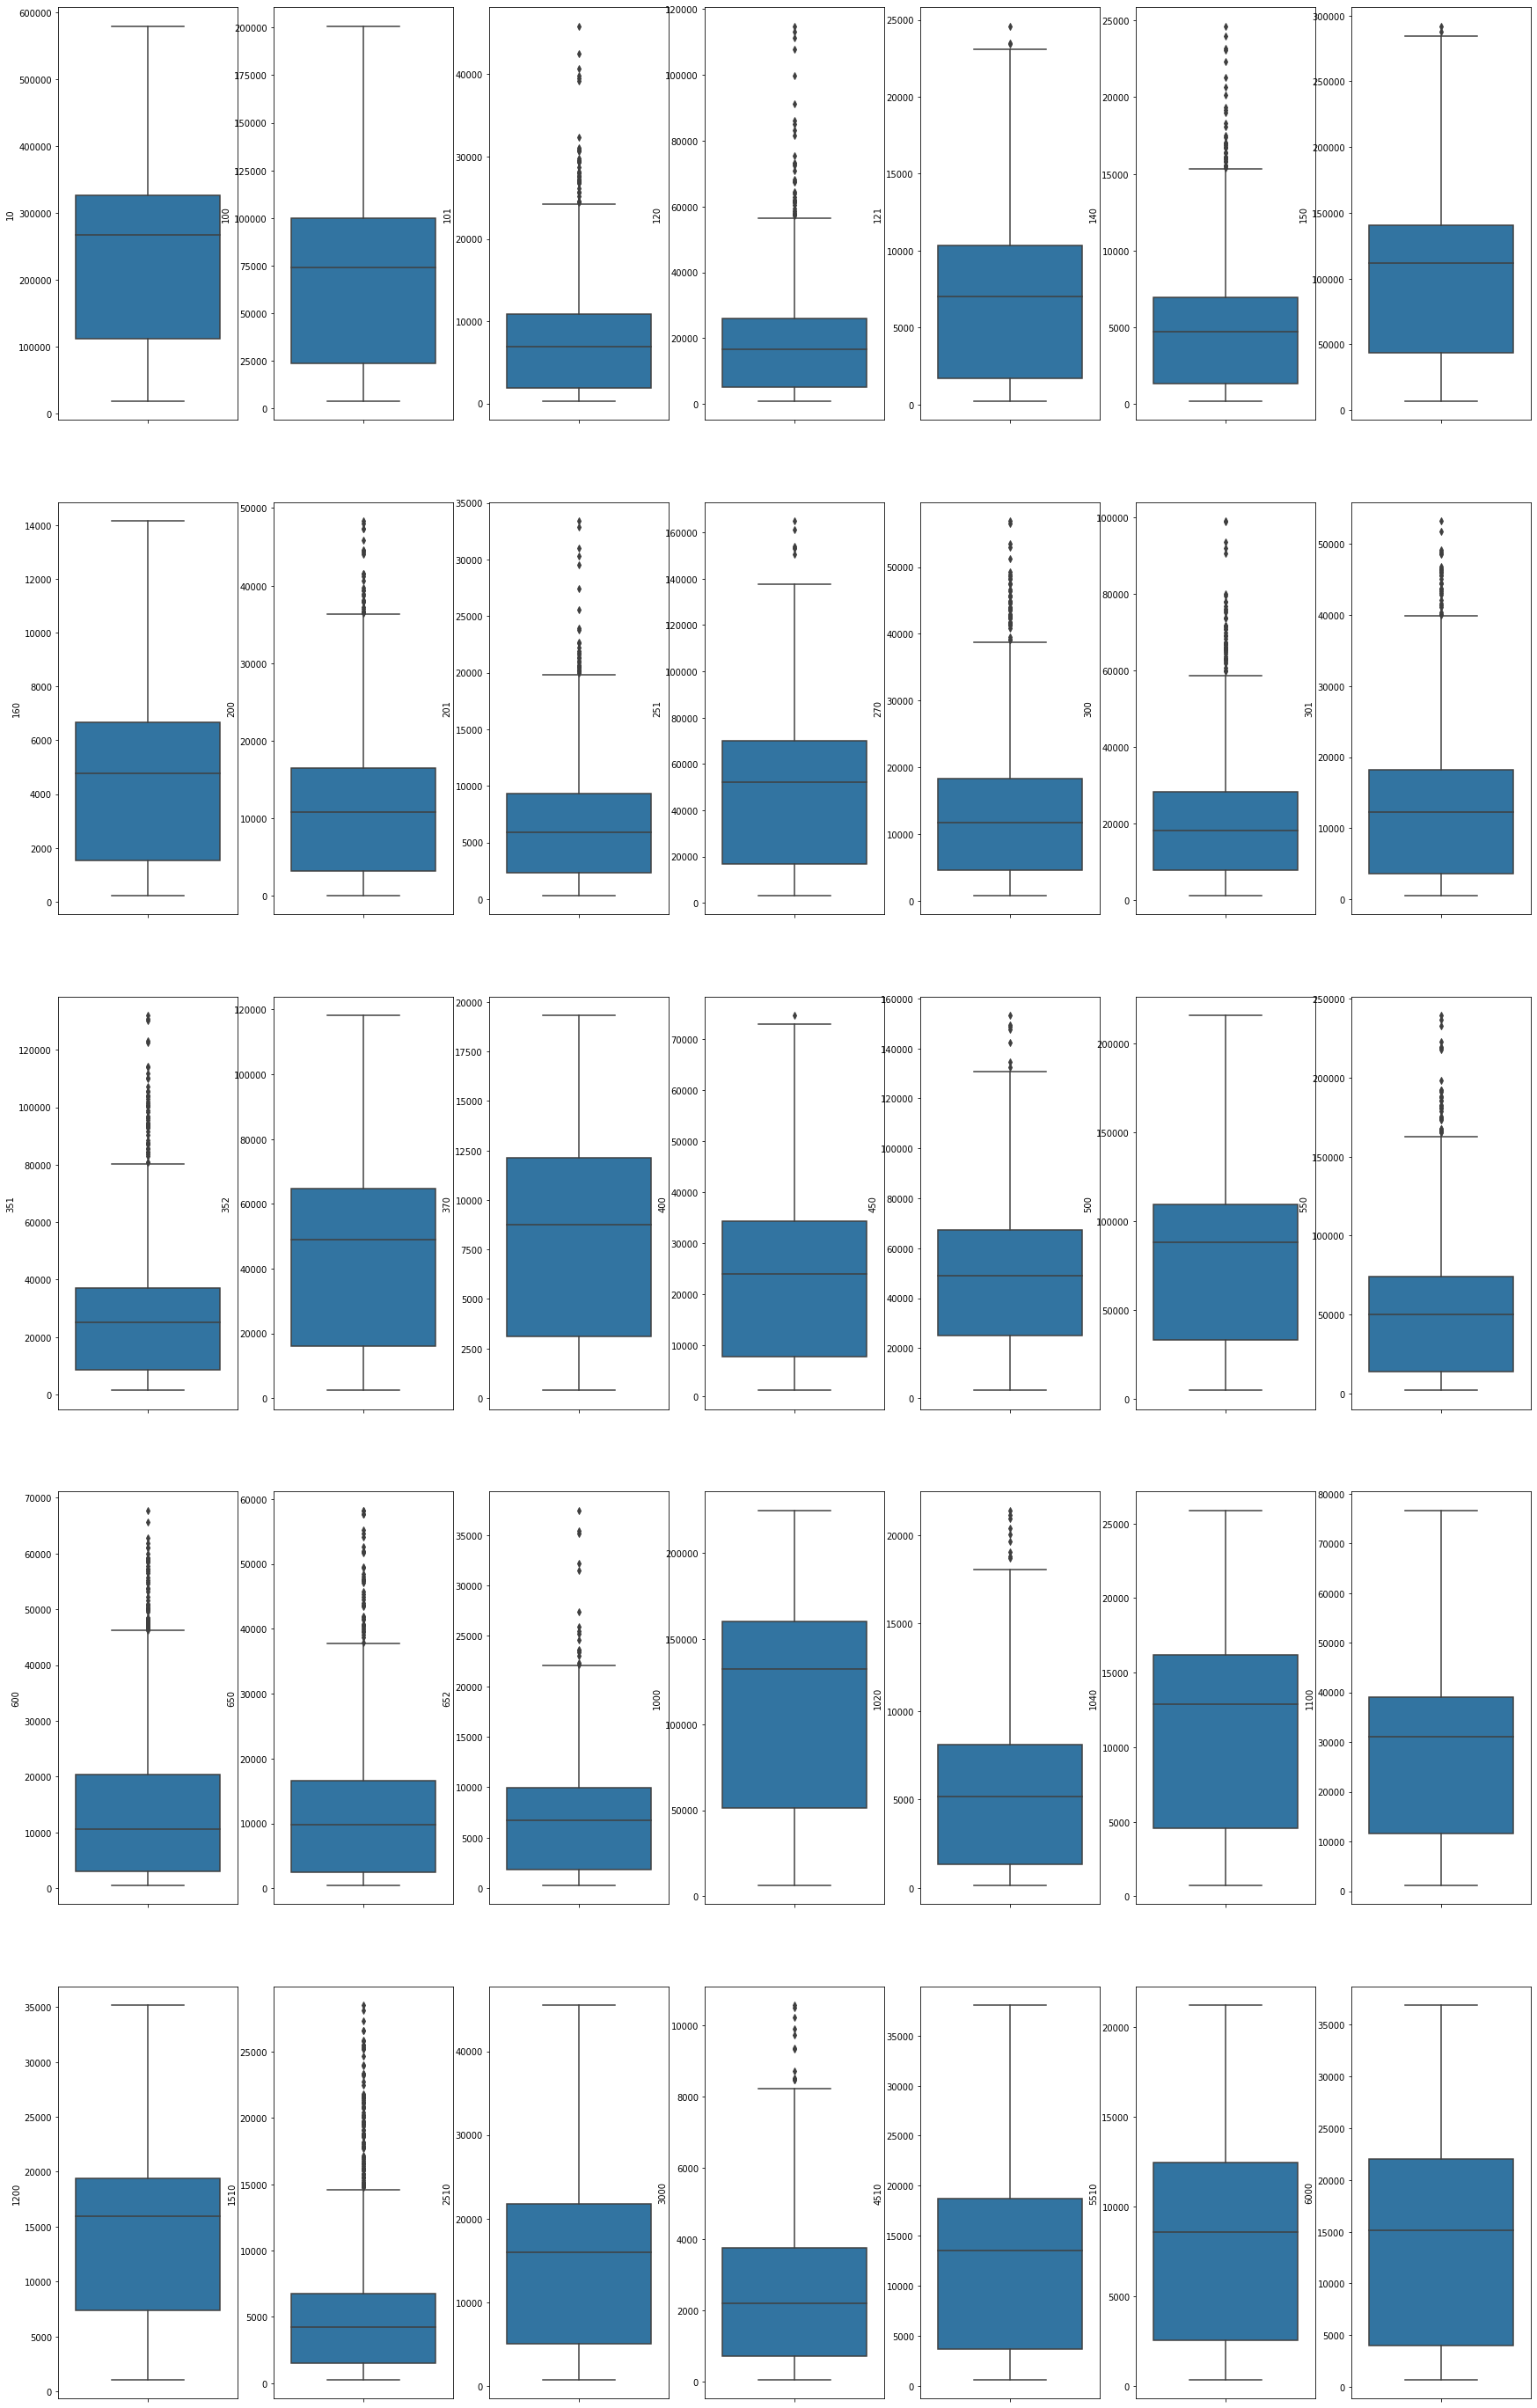

In [95]:
import seaborn as sns


plt.figure(figsize=(30,50))
count = 1

for col in new_df.columns[3:]:
    plt.subplot(5, 7, count)
    p = sns.boxplot(y= new_df[col])
    count += 1
plt.show()

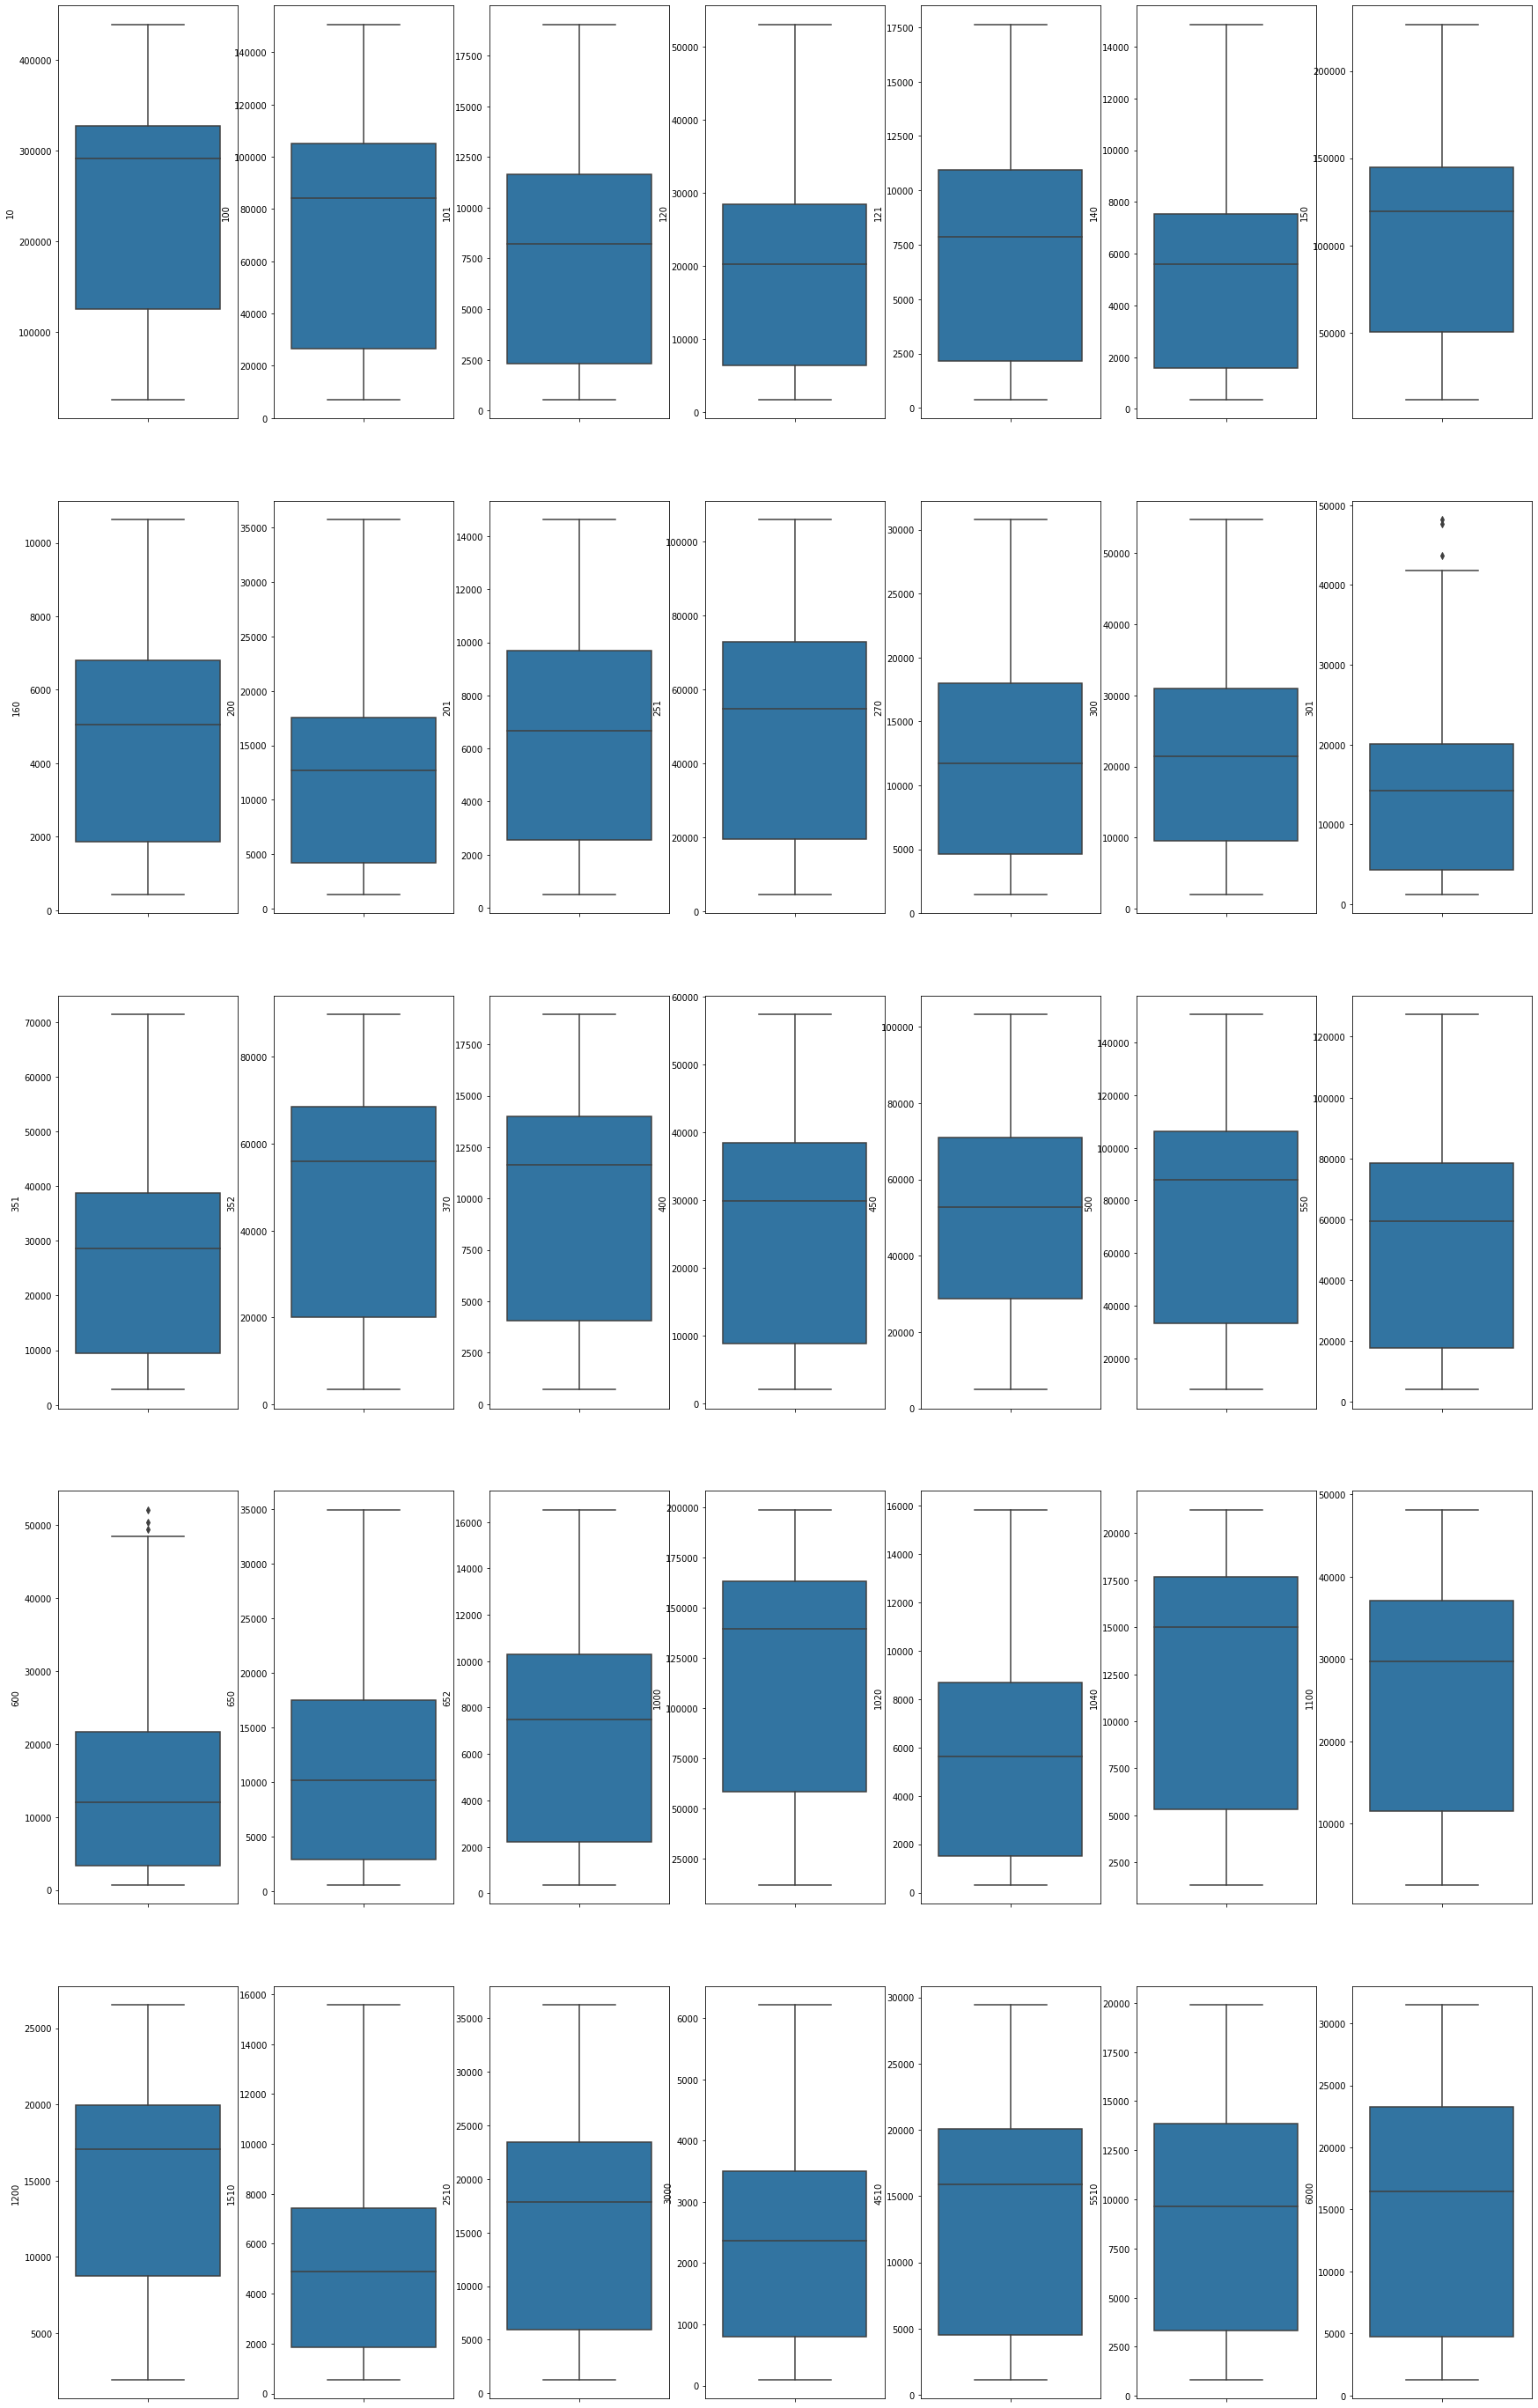

In [98]:
plt.figure(figsize=(30,50))
count=1
for col in validation_df.columns[2:]:
    plt.subplot(5, 7, count)
    p = sns.boxplot(y= validation_df[col])
    count += 1
plt.show()

## MA7

In [99]:
per_date = new_df2.groupby(['날짜']).sum().reset_index()
per_date = per_date.drop(columns='시간')
per_date['날짜'] = pd.to_datetime(per_date['날짜'], format="%Y%m%d")

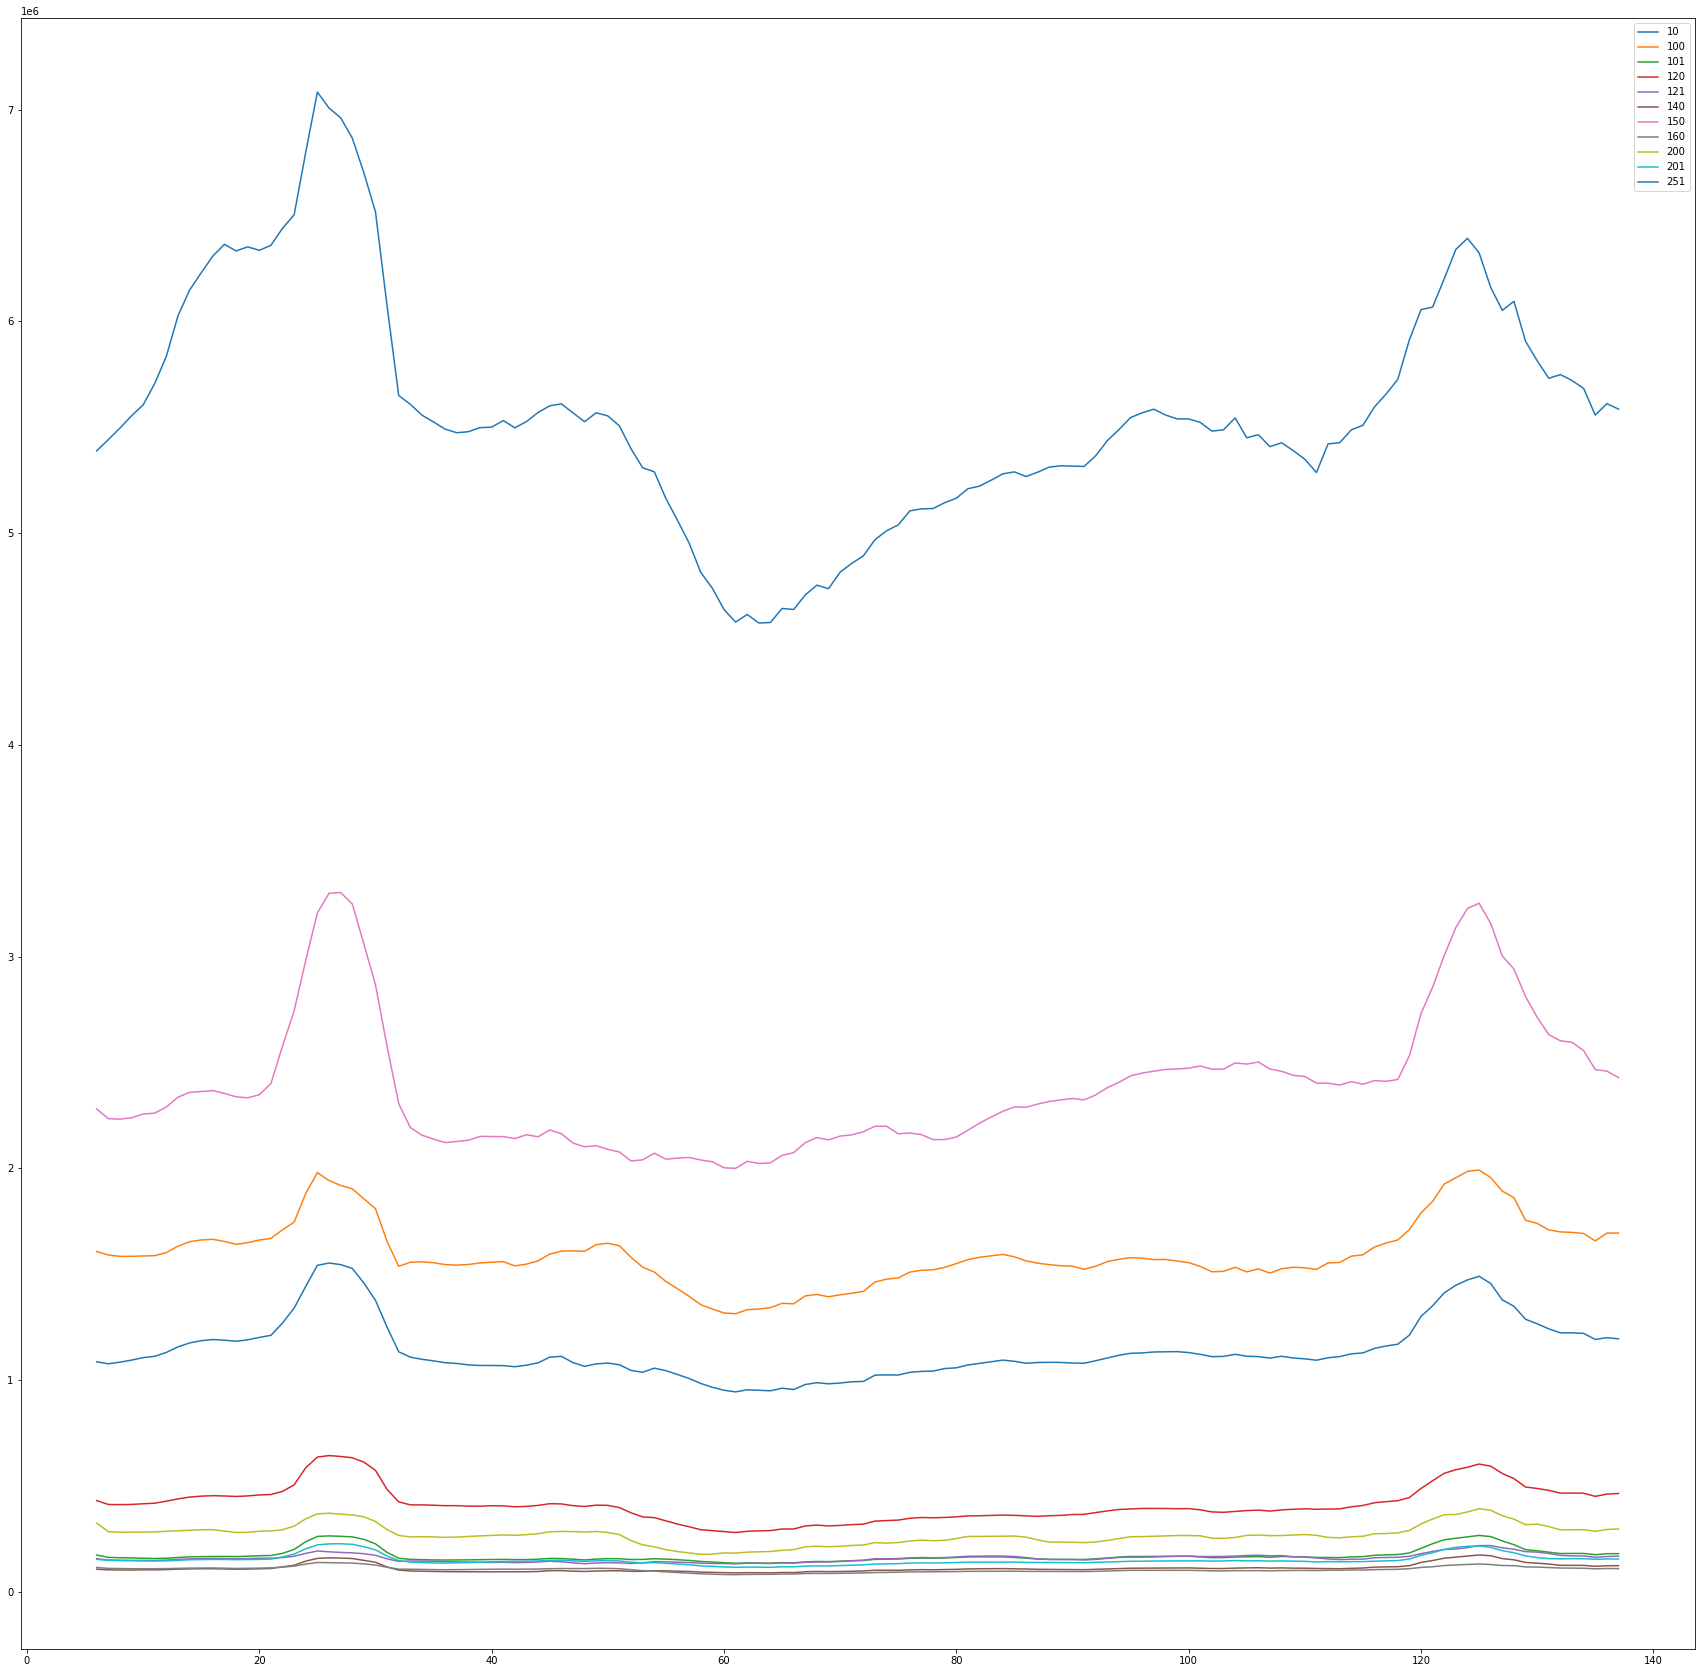

In [116]:
plt.figure(figsize=(30,30))
for col in per_date.columns[1:12]:
    plt.plot(per_date[col].rolling(window=7).mean(), label=col)

plt.legend()
plt.show()

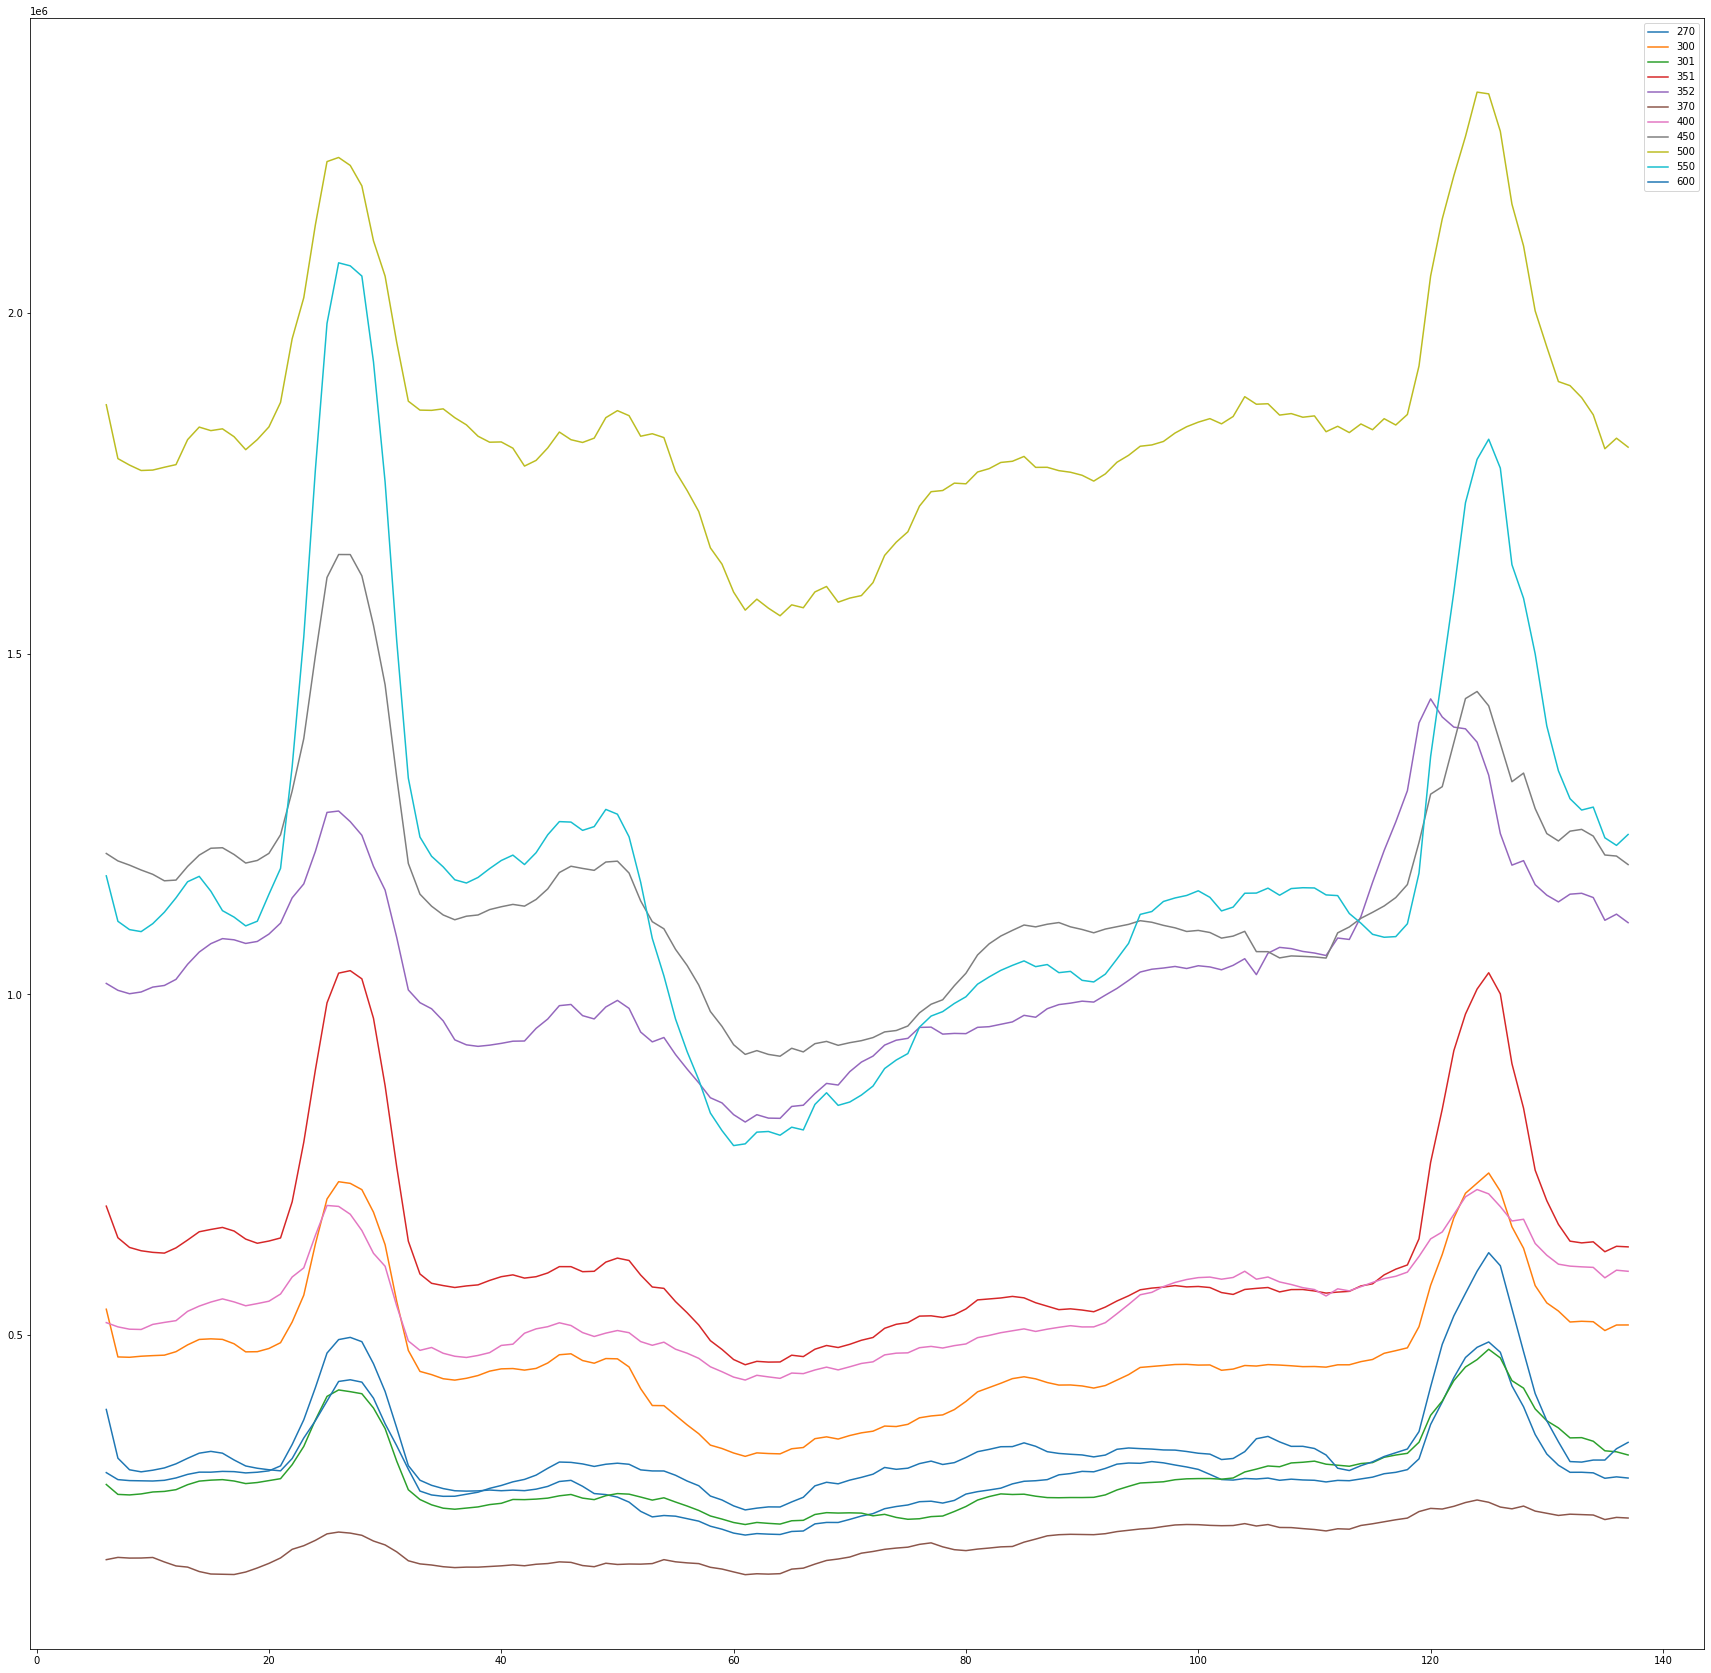

In [117]:
plt.figure(figsize=(30,30))
for col in per_date.columns[12:23]:
    plt.plot(per_date[col].rolling(window=7).mean(), label=col)

plt.legend()
plt.show()

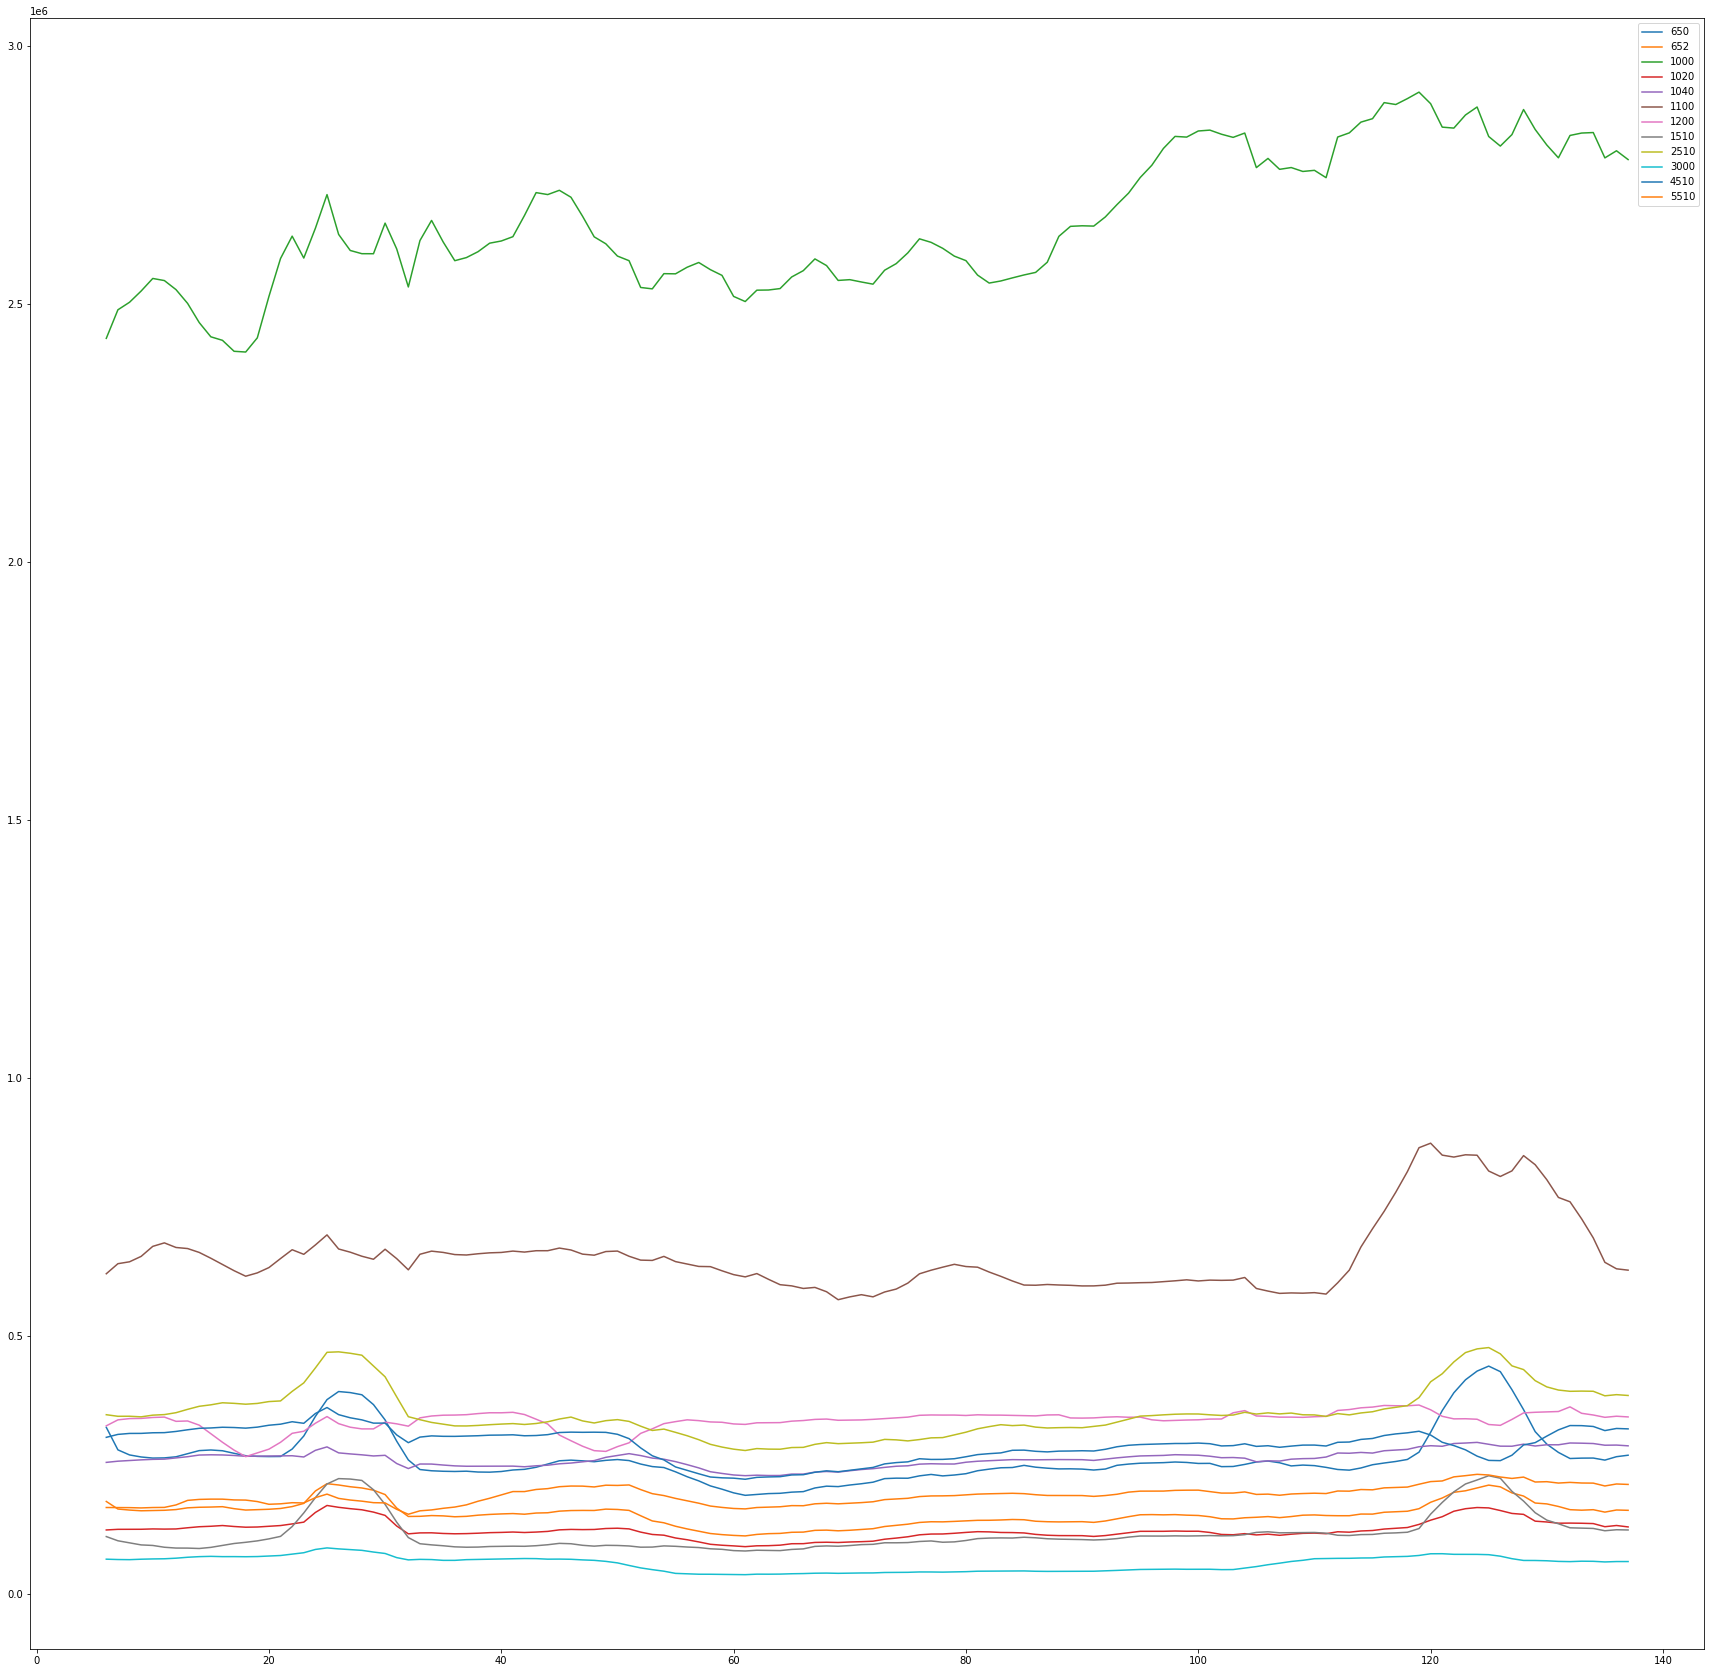

In [120]:
# 1000번 : 자신만의 변동, 남들과 반대(최근) : 4510 1200
plt.figure(figsize=(30,30))
for col in per_date.columns[23:-1]:
    plt.plot(per_date[col].rolling(window=7).mean(), label=col)

plt.legend()
plt.show()